#**SUMMARY**
This notebook implements AQW-RE (Adaptive Quantum Walk + Resistance Embedding) — a new hybrid feature-mapping approach for graph classification.
It combines local Weisfeiler–Lehman patterns, quantum-walk–based spectral dynamics, effective resistance statistics, and global Laplacian features into one normalized vector per graph.
These features capture both local chemical motifs and global connectivity patterns across multiple scales.
The method includes an Adaptive Entanglement Descriptor (AED) that modulates the simulated quantum circuit parameters based on each graph’s spectrum, making the quantum embedding graph-aware.
After feature extraction, the model evaluates both classical (SVM) and quantum-inspired (Qulacs) embeddings using 10-fold cross-validation with no PCA leakage.
The approach is general and works on standard TU datasets like MUTAG, PROTEINS, AIDS, PTC-MR, and NCI1.

#**NCI1 Dataset**

QURI Parts available: True   QURI->Qulacs bridge: True
NCI1_A.txt                               exists: True
NCI1_graph_indicator.txt                 exists: True
NCI1_graph_labels.txt                    exists: True
NCI1_node_labels.txt                     exists: True

Loaded 4110 graphs. Example sizes:
 G#1: nodes=21, edges=21
 G#2: nodes=24, edges=26
 G#3: nodes=29, edges=29
 G#4: nodes=28, edges=31
 G#5: nodes=23, edges=23

Computing AQW-RE features for all graphs...


100%|██████████| 4110/4110 [01:03<00:00, 64.75it/s]


Feature matrix shape: (4110, 1063)

=== Classical SVM on AQW-RE features (PCA inside CV) ===
Kernel=linear | Acc=0.7302 ± 0.0242 | F1-macro=0.7292 ± 0.0243
Kernel=rbf    | Acc=0.8200 ± 0.0141 | F1-macro=0.8196 ± 0.0140

=== Quantum-inspired per-fold embedding (via QURI Parts) ===
(quantum) Kernel=linear | Acc=0.7241 ± 0.0227 | F1-macro=0.7234 ± 0.0226
(quantum) Kernel=rbf    | Acc=0.7277 ± 0.0228 | F1-macro=0.7273 ± 0.0227

############################################################
Summary (classical):
 linear -> accuracy=0.7302 ± 0.0242, f1_macro=0.7292 ± 0.0243
 rbf    -> accuracy=0.8200 ± 0.0141, f1_macro=0.8196 ± 0.0140

Summary (quantum-inspired):
 linear -> accuracy=0.7241 ± 0.0227, f1_macro=0.7234 ± 0.0226
 rbf    -> accuracy=0.7277 ± 0.0228, f1_macro=0.7273 ± 0.0227

Done. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).

Running tiny QURI embedding test...
quri embedding shape: (3, 4)
[[ 1.          1.          1.          1.  

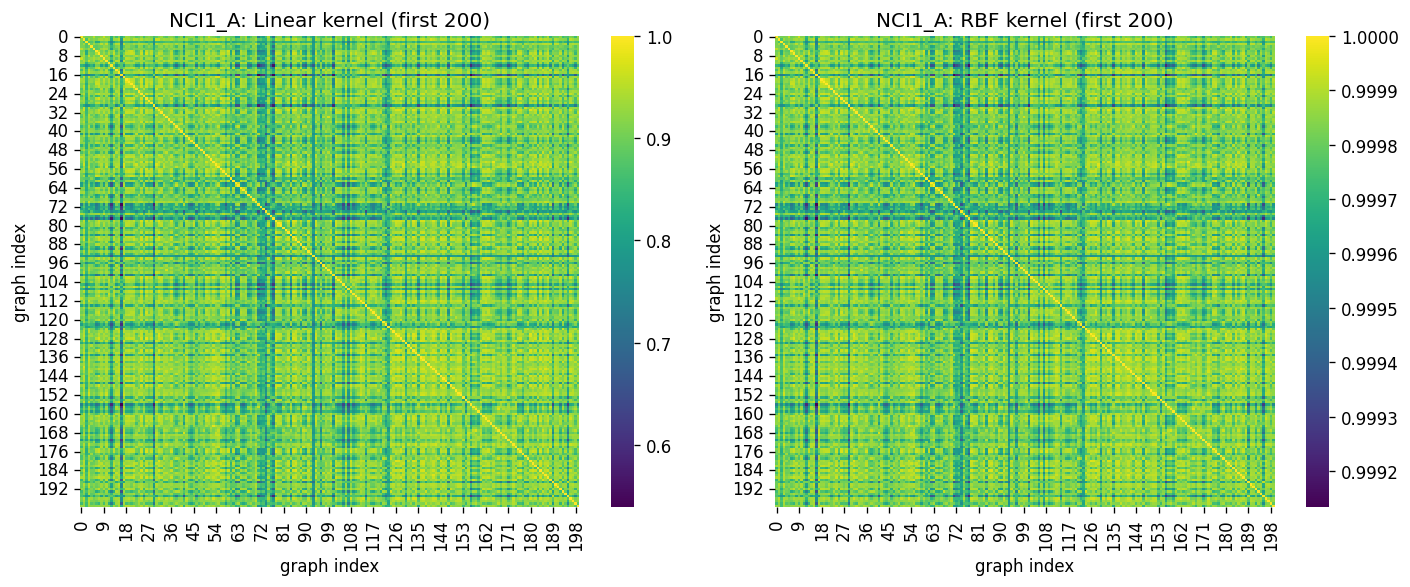

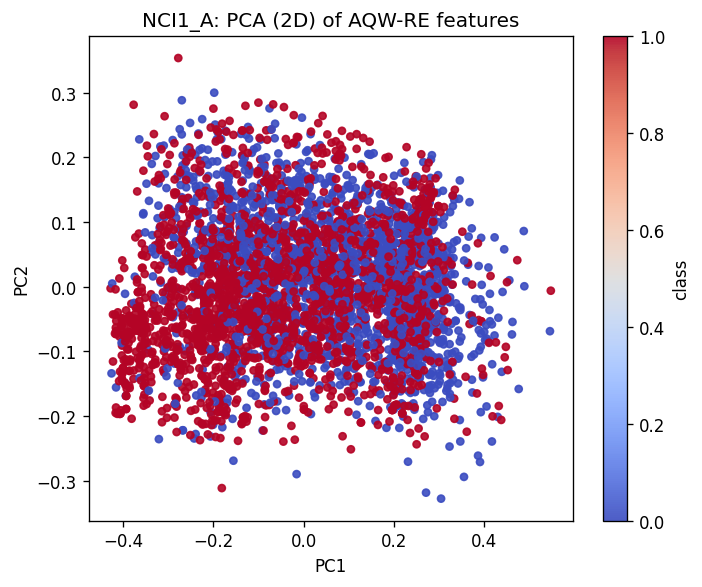

Skipping t-SNE for NCI1_A (n=4110 > 2000).
Computing quantum embeddings for 200 samples (n_qubits=6)...


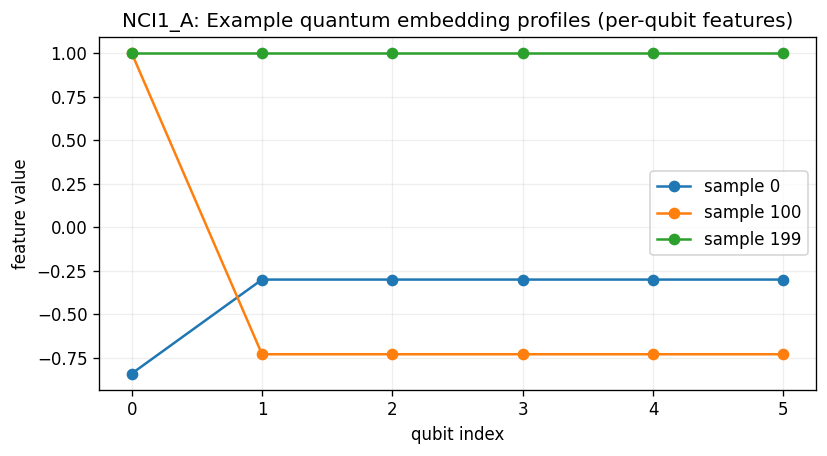

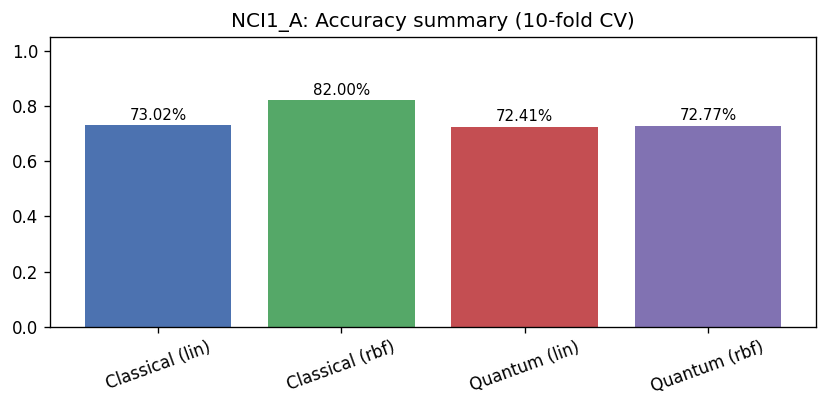

In [ ]:
# ---------- AQW-RE full script (Colab/Jupyter-ready) ----------
# Paste into a cell. Change only the 4 filenames below for each dataset.

# ---------- (UNCOMMENT ON FIRST RUN) install deps ----------
!pip install --quiet networkx pandas scikit-learn tqdm
!pip install --quiet "quri-parts[qulacs]"  # optional extras: qulacs bridge if desired

# ---------- Imports ----------
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import hashlib
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- QURI Parts availability ----------
try:
    from quri_parts.circuit import QuantumCircuit
    from quri_parts.core.state import quantum_state, apply_circuit
    try:
        from quri_parts.qulacs.simulator import evaluate_state_to_vector, run_circuit
        _QURI_HAVE_QLACS_BRIDGE = True
    except Exception:
        evaluate_state_to_vector = None
        try:
            from quri_parts.qulacs.simulator import run_circuit
            _QURI_HAVE_QLACS_BRIDGE = True
        except Exception:
            run_circuit = None
            _QURI_HAVE_QLACS_BRIDGE = False
    HAS_QURI = True
except Exception:
    HAS_QURI = False
    _QURI_HAVE_QLACS_BRIDGE = False

print("QURI Parts available:", HAS_QURI, "  QURI->Qulacs bridge:", _QURI_HAVE_QLACS_BRIDGE)

# ========== USER: set dataset files (change per dataset cell) ==========
A_FILE  = "NCI1_A.txt"                        # edge list file (u,v) rows, 1-indexed
GI_FILE = "NCI1_graph_indicator.txt"         # node -> graph id (one integer per node)
GL_FILE = "NCI1_graph_labels.txt"            # graph label per graph
NL_FILE = "NCI1_node_labels.txt"             # node labels (one per node)
# ======================================================================

# Quick file existence check
for f in (A_FILE, GI_FILE, GL_FILE, NL_FILE):
    print(f"{f:40s} exists: {os.path.exists(f)}")

# ---------- Load data (robust pandas usage) ----------
edges = pd.read_csv(A_FILE, header=None, sep=",", engine="python").values.astype(int)
graph_indicator = pd.read_csv(GI_FILE, header=None).iloc[:, 0].values
graph_labels = pd.read_csv(GL_FILE, header=None).iloc[:, 0].values
node_labels = pd.read_csv(NL_FILE, header=None).iloc[:, 0].values

n_nodes = len(graph_indicator)
node_to_graph = {i+1: int(graph_indicator[i]) for i in range(n_nodes)}
n_graphs = int(len(graph_labels))
graphs = {gid: nx.Graph() for gid in range(1, n_graphs+1)}

# Add nodes
for node_idx in range(1, n_nodes+1):
    gid = node_to_graph[node_idx]
    lab = node_labels[node_idx-1] if node_idx-1 < len(node_labels) else 0
    graphs[gid].add_node(node_idx, label=str(lab))

# Add edges (skip edges that cross graphs)
for u, v in edges:
    u = int(u); v = int(v)
    if node_to_graph.get(u, -1) != node_to_graph.get(v, -2):
        continue
    graphs[node_to_graph[u]].add_edge(u, v)

graph_list = [graphs[gid] for gid in range(1, n_graphs+1)]
y = np.array(graph_labels, dtype=int)

print(f"\nLoaded {len(graph_list)} graphs. Example sizes:")
for i, G in enumerate(graph_list[:5]):
    print(f" G#{i+1}: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
print()

# ---------- AQW-RE component functions ----------

def wl_modified_counts(G, h=3):
    labels = {n: str(G.nodes[n].get("label", str(G.degree[n]))) for n in G.nodes()}
    counter = {}
    for lab in labels.values():
        counter["v0_"+lab] = counter.get("v0_"+lab, 0) + 1
    for it in range(1, h+1):
        new_labels = {}
        for n in G.nodes():
            neigh_labs = sorted([labels[nb] for nb in G.neighbors(n)])
            deg_pattern = [0,0,0,0]
            for nb in G.neighbors(n):
                d = G.degree[nb]
                if d == 1: deg_pattern[0]+=1
                elif d == 2: deg_pattern[1]+=1
                elif d == 3: deg_pattern[2]+=1
                else: deg_pattern[3]+=1
            deg_pattern_str = "dpat:" + ",".join(map(str,deg_pattern))
            long_lab = labels[n] + "|" + "|".join(neigh_labs) + "|" + deg_pattern_str
            lab_hash = hashlib.sha1((f"v{it}_" + long_lab).encode()).hexdigest()
            new_labels[n] = lab_hash
            key = f"v{it}_{lab_hash[:16]}"
            counter[key] = counter.get(key, 0) + 1
        labels = new_labels
    return counter

def wl_counter_to_vector(counter, n_bits=1024, n_hash_rounds=2):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def effective_resistance_stats(G, sample_limit=300):
    n = G.number_of_nodes()
    if n <= 1:
        return np.array([0.0, 0.0])
    L = nx.laplacian_matrix(G).astype(float).toarray()
    L_pinv = np.linalg.pinv(L)
    m = min(sample_limit, n*(n-1)//2)
    resistances = []
    if m == n*(n-1)//2:
        for i_idx in range(n):
            for j_idx in range(i_idx+1, n):
                r = L_pinv[i_idx, i_idx] + L_pinv[j_idx, j_idx] - 2*L_pinv[i_idx, j_idx]
                resistances.append(r)
    else:
        rng = np.random.default_rng(42)
        sampled = set()
        while len(sampled) < m:
            i_idx = int(rng.integers(0, n)); j_idx = int(rng.integers(0, n))
            if i_idx == j_idx: continue
            a,b = min(i_idx, j_idx), max(i_idx, j_idx)
            if (a,b) in sampled: continue
            sampled.add((a,b))
            r = L_pinv[a,a] + L_pinv[b,b] - 2*L_pinv[a,b]
            resistances.append(r)
    resistances = np.array(resistances)
    if resistances.size == 0:
        return np.array([0.0, 0.0])
    mean_r = np.mean(resistances); std_r = np.std(resistances)
    return np.array([mean_r / (n+1e-12), std_r / (n+1e-12)])

def spectral_moments(G, k=6):
    if G.number_of_nodes() == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    if len(evals) >= k:
        return np.real(evals[:k])
    else:
        out = np.zeros(k); out[:len(evals)] = evals; return out

def ctqw_signature(G, times=(0.05, 0.2, 0.8), r_eig=20):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(len(times)*4)
    L = nx.laplacian_matrix(G).astype(float).toarray()
    try:
        evals, evecs = np.linalg.eigh(L)
    except Exception:
        evals, evecs = np.linalg.eig(L); evals = np.real(evals); evecs = np.real(evecs)
    r = min(r_eig, n)
    idx = np.argsort(evals)[:r]
    lam = evals[idx]; vecs = evecs[:, idx]
    feats = []
    for t in times:
        phases = np.exp(-1j * lam * t)
        U_approx = (vecs * phases) @ vecs.T
        probs = np.abs(U_approx)**2
        row_mean = probs.mean(axis=1)
        feats.append(row_mean.mean())
        feats.append(row_mean.std())
        feats.append(probs.mean())
        feats.append(np.trace(probs)/max(1,n))
    return np.array(feats)

def adaptive_entanglement_descriptor(G, k=8):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    topk = evals[:k] if len(evals) >= k else np.concatenate([evals, np.zeros(k-len(evals))])
    topk = np.array(topk, dtype=float)
    if np.linalg.norm(topk) > 0:
        topk = topk / (np.linalg.norm(topk)+1e-12)
    return topk

def degree_pattern_vector(G):
    deg_counts = [0,0,0,0,0]
    for n in G.nodes():
        d = G.degree[n]
        if d == 0: deg_counts[0]+=1
        elif d == 1: deg_counts[1]+=1
        elif d == 2: deg_counts[2]+=1
        elif d == 3: deg_counts[3]+=1
        else: deg_counts[4]+=1
    deg_counts = np.array(deg_counts, dtype=float)
    deg_counts = deg_counts / (deg_counts.sum() + 1e-12)
    label_counter = {}
    for n in G.nodes():
        lab = str(G.nodes[n].get("label", "0"))
        label_counter[lab] = label_counter.get(lab, 0) + 1
    K = 8
    buckets = np.zeros(K, dtype=float)
    for lab, cnt in label_counter.items():
        idx = int(hashlib.md5(lab.encode()).hexdigest(), 16) % K
        buckets[idx] += cnt
    if buckets.sum() > 0:
        buckets = buckets / buckets.sum()
    return np.concatenate([deg_counts, buckets])

def hash_counter_to_vector(counter, n_bits=2048, n_hash_rounds=3):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def aqw_re_feature(G):
    wl_counter = wl_modified_counts(G, h=3)
    wl_vec = wl_counter_to_vector(wl_counter, n_bits=1024, n_hash_rounds=2)
    ct = ctqw_signature(G, times=(0.05,0.2,0.8), r_eig=20)
    er = effective_resistance_stats(G, sample_limit=300)
    spec = spectral_moments(G, k=6)
    deg = degree_pattern_vector(G)
    aed = adaptive_entanglement_descriptor(G, k=6)
    feat = np.concatenate([wl_vec, ct, er, spec, deg, aed])
    if np.linalg.norm(feat) > 0:
        feat = feat / (np.linalg.norm(feat) + 1e-12)
    return feat

# ---------- Compute features ----------
print("Computing AQW-RE features for all graphs...")
FEATURES = []
for G in tqdm(graph_list):
    FEATURES.append(aqw_re_feature(G))
X = np.vstack(FEATURES)
print("Feature matrix shape:", X.shape)

# ---------- Evaluation helpers (no PCA leakage) ----------
PCA_DIM = 120
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_macro': make_scorer(f1_score, average='macro')}

def evaluate_and_report_classical(X_feat, y, kernels=("linear","rbf")):
    results = {}
    for kernel in kernels:
        pipe = make_pipeline(PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42),
                             SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42))
        cv_res = cross_validate(pipe, X_feat, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
        acc_mean = np.mean(cv_res['test_accuracy']); acc_std = np.std(cv_res['test_accuracy'])
        f1_mean = np.mean(cv_res['test_f1_macro']); f1_std = np.std(cv_res['test_f1_macro'])
        results[kernel] = {'accuracy': (acc_mean, acc_std), 'f1_macro': (f1_mean, f1_std), 'cv_details': cv_res}
        print(f"Kernel={kernel:6s} | Acc={acc_mean:.4f} ± {acc_std:.4f} | F1-macro={f1_mean:.4f} ± {f1_std:.4f}")
    return results

# ---------- QURI Parts quantum embedding (replacement for the Qulacs routine) ----------
def quantum_embedding_features_quri(X_in, n_qubits=15):
    if not HAS_QURI:
        raise RuntimeError("QURI Parts (quri-parts) not available. Install quri-parts and extras if needed.")
    X = np.array(X_in, dtype=float)
    if X.shape[1] < n_qubits:
        X_pad = np.hstack([X, np.zeros((X.shape[0], n_qubits - X.shape[1]))])
    else:
        X_pad = X[:, :n_qubits]
    mins = X_pad.min(axis=0); maxs = X_pad.max(axis=0)
    ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
    X_angles = 2 * np.pi * (X_pad - mins) / ranges
    n_samples = X_angles.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)
    dim = 1 << n_qubits
    idxs = np.arange(dim, dtype=np.uint32)
    bit_masks = [((idxs >> q) & 1).astype(np.uint8) for q in range(n_qubits)]

    for i in range(n_samples):
        angles = X_angles[i]
        circ = QuantumCircuit(n_qubits)
        for q in range(n_qubits):
            circ.add_RY_gate(q, float(angles[q]))
        for q in range(n_qubits - 1):
            circ.add_CNOT_gate(q, q + 1)
        state = quantum_state(n_qubits)
        state = apply_circuit(circ, state)
        if 'evaluate_state_to_vector' in globals() and evaluate_state_to_vector is not None:
            vec = evaluate_state_to_vector(state).vector
        elif 'run_circuit' in globals() and run_circuit is not None:
            init_vec = np.zeros(1 << n_qubits, dtype=complex); init_vec[0] = 1.0
            out = run_circuit(circ, init_vec)
            vec = out if isinstance(out, np.ndarray) else getattr(out, "vector", np.asarray(out))
        else:
            try:
                vec = state.vector
            except Exception as e:
                raise RuntimeError("Could not extract state vector from QURI Parts state; "
                                   "install quri-parts[qulacs] or update quri-parts.") from e
        probs = np.abs(vec)**2
        for q in range(n_qubits):
            bm = bit_masks[q]
            features[i, q] = float(np.dot(probs, 1.0 - 2.0 * bm))

    return features

def evaluate_and_report_quantum(X_feat, y, kernels=("linear","rbf"), n_qubits=6):
    if not HAS_QURI:
        print("[QURI Parts not available] skipping quantum evaluation."); return None
    accs = {k: [] for k in kernels}
    f1s = {k: [] for k in kernels}
    for train_idx, test_idx in cv.split(X_feat, y):
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        pca = PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42)
        Xtr_red = pca.fit_transform(X_train); Xte_red = pca.transform(X_test)
        qtr = quantum_embedding_features_quri(Xtr_red, n_qubits=n_qubits)
        qte = quantum_embedding_features_quri(Xte_red, n_qubits=n_qubits)
        Xtr_cat = np.hstack([Xtr_red, qtr]); Xte_cat = np.hstack([Xte_red, qte])
        for kernel in kernels:
            clf = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
            clf.fit(Xtr_cat, y_train)
            y_pred = clf.predict(Xte_cat)
            accs[kernel].append(accuracy_score(y_test, y_pred))
            f1s[kernel].append(f1_score(y_test, y_pred, average='macro'))
    results = {}
    for kernel in kernels:
        results[kernel] = {'accuracy': (np.mean(accs[kernel]), np.std(accs[kernel])),
                           'f1_macro': (np.mean(f1s[kernel]), np.std(f1s[kernel])),
                           'fold_accs': accs[kernel], 'fold_f1s': f1s[kernel]}
        print(f"(quantum) Kernel={kernel:6s} | Acc={results[kernel]['accuracy'][0]:.4f} ± {results[kernel]['accuracy'][1]:.4f} | "
              f"F1-macro={results[kernel]['f1_macro'][0]:.4f} ± {results[kernel]['f1_macro'][1]:.4f}")
    return results

# ---------- Run classical evaluation ----------
print("\n=== Classical SVM on AQW-RE features (PCA inside CV) ===")
classical_results = evaluate_and_report_classical(X, y, kernels=("linear","rbf"))

# ---------- Optionally run quantum-inspired evaluation (per-fold PCA) ----------
USE_QUANTUM = HAS_QURI and True
if USE_QUANTUM:
    print(f"\n=== Quantum-inspired per-fold embedding (via QURI Parts) ===")
    quantum_results = evaluate_and_report_quantum(X, y, kernels=("linear","rbf"), n_qubits=6)
else:
    quantum_results = None

# ---------- Summary ----------
print("\n" + "#"*60)
print("Summary (classical):")
for k, v in classical_results.items():
    acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
    print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

if quantum_results:
    print("\nSummary (quantum-inspired):")
    for k, v in quantum_results.items():
        acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
        print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

print("\nDone. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).")

# ---------- Quick unit test to check QURI embedding (small) ----------
if HAS_QURI:
    try:
        print("\nRunning tiny QURI embedding test...")
        small_X = np.random.randn(3, 10)  # 3 samples, 10 dims
        qfeat = quantum_embedding_features_quri(small_X, n_qubits=4)
        print("quri embedding shape:", qfeat.shape)
        print(qfeat)
    except Exception as e:
        print("QURI embedding test failed:", str(e))
else:
    print("Skipping QURI embedding test because quri-parts is not available.")



# ----------------- Visualization-----------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

plt.rcParams.update({"figure.dpi": 120})
dataset_name = os.path.splitext(A_FILE)[0] if 'A_FILE' in globals() else "dataset"

n = X.shape[0]
# choose subset for kernel heatmaps (keeps execution & plots readable)
subset_n = min(200, n)
subset_idx = np.arange(subset_n)

# --- 1) Kernel heatmaps (linear & RBF on subset) ---
K_lin = linear_kernel(X[subset_idx])
K_rbf = rbf_kernel(X[subset_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(K_lin, ax=axes[0], cmap="viridis")
axes[0].set_title(f"{dataset_name}: Linear kernel (first {subset_n})")
axes[0].set_xlabel("graph index"); axes[0].set_ylabel("graph index")

sns.heatmap(K_rbf, ax=axes[1], cmap="viridis")
axes[1].set_title(f"{dataset_name}: RBF kernel (first {subset_n})")
axes[1].set_xlabel("graph index"); axes[1].set_ylabel("graph index")

plt.tight_layout()
plt.show()

# --- 2) PCA 2D scatter of full X ---
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
plt.figure(figsize=(6,5))
sc = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, s=18, cmap="coolwarm", alpha=0.9)
plt.title(f"{dataset_name}: PCA (2D) of AQW-RE features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, label="class")
plt.tight_layout()
plt.show()

# --- 3) t-SNE (only when manageable) ---
if n <= 2000:
    print("Running t-SNE (this can take a while for large datasets)...")
    tsne = TSNE(n_components=2, init='pca', random_state=42, learning_rate='auto', perplexity=30)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=10, cmap="coolwarm", alpha=0.9)
    plt.title(f"{dataset_name}: t-SNE (2D) of AQW-RE features")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.colorbar(label="class")
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping t-SNE for {dataset_name} (n={n} > 2000).")

# --- 4) Quantum embedding feature examples (if QURI available) ---
try:
    if HAS_QURI and 'quantum_embedding_features_quri' in globals():
        # pick a small n_qubits for visualization (use same value as evaluation if set)
        vis_n_qubits = 6 if 'n_qubits' not in globals() else int(n_qubits)
        vis_n_qubits = min(vis_n_qubits, X.shape[1])  # don't exceed feature dim
        # compute on a small subset to save time if dataset large
        q_subset = min(200, n)
        print(f"Computing quantum embeddings for {q_subset} samples (n_qubits={vis_n_qubits})...")
        X_for_q = X[:q_subset]
        q_emb = quantum_embedding_features_quri(X_for_q, n_qubits=vis_n_qubits)
        # show 3 example profiles
        ex_idx = [0, q_subset//2, q_subset-1] if q_subset>=3 else list(range(q_subset))
        plt.figure(figsize=(7,3 + len(ex_idx)*0.3))
        for i, idx in enumerate(ex_idx):
            plt.plot(q_emb[idx], marker='o', label=f"sample {idx}")
        plt.title(f"{dataset_name}: Example quantum embedding profiles (per-qubit features)")
        plt.xlabel("qubit index"); plt.ylabel("feature value")
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print("QURI Parts not available or quantum function missing — skipping quantum plots.")
except Exception as e:
    print("Quantum embedding plotting failed (skipping). Error:", e)

# --- 5) Accuracy summary bar chart (classical_results & quantum_results) ---
def _get_acc(res_dict, key):
    try:
        return res_dict.get(key, {}).get('accuracy', (np.nan, np.nan))[0]
    except Exception:
        return np.nan

cls_lin = _get_acc(classical_results, 'linear') if 'classical_results' in globals() else np.nan
cls_rbf = _get_acc(classical_results, 'rbf') if 'classical_results' in globals() else np.nan
q_lin = _get_acc(quantum_results, 'linear') if 'quantum_results' in globals() and quantum_results else np.nan
q_rbf = _get_acc(quantum_results, 'rbf') if 'quantum_results' in globals() and quantum_results else np.nan

labels = []
vals = []
if not np.isnan(cls_lin):
    labels.append('Classical (lin)'); vals.append(cls_lin)
if not np.isnan(cls_rbf):
    labels.append('Classical (rbf)'); vals.append(cls_rbf)
if not np.isnan(q_lin):
    labels.append('Quantum (lin)'); vals.append(q_lin)
if not np.isnan(q_rbf):
    labels.append('Quantum (rbf)'); vals.append(q_rbf)

if len(labels) > 0:
    x = np.arange(len(labels))
    plt.figure(figsize=(7,3.5))
    bars = plt.bar(x, vals, color=['#4C72B0','#55A868','#C44E52','#8172B2'][:len(labels)])
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=9)
    plt.ylim(0, 1.05)
    plt.xticks(x, labels, rotation=20)
    plt.title(f"{dataset_name}: Accuracy summary (10-fold CV)")
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy results found to plot summary.")

# ----------------- End visualization cell -----------------



#**AIDS Dataset**

QURI Parts available: True   QURI->Qulacs bridge: True
AIDS_A.txt                               exists: True
AIDS_graph_indicator.txt                 exists: True
AIDS_graph_labels.txt                    exists: True
AIDS_node_labels.txt                     exists: True

Loaded 2000 graphs. Example sizes:
 G#1: nodes=47, edges=53
 G#2: nodes=11, edges=11
 G#3: nodes=9, edges=8
 G#4: nodes=10, edges=10
 G#5: nodes=16, edges=17

Computing AQW-RE features for all graphs...


100%|██████████| 2000/2000 [00:19<00:00, 103.42it/s]


Feature matrix shape: (2000, 1063)

=== Classical SVM on AQW-RE features (PCA inside CV) ===
Kernel=linear | Acc=0.9935 ± 0.0059 | F1-macro=0.9896 ± 0.0096
Kernel=rbf    | Acc=0.9955 ± 0.0065 | F1-macro=0.9928 ± 0.0105

=== Quantum-inspired per-fold embedding (via QURI Parts) ===
(quantum) Kernel=linear | Acc=0.9935 ± 0.0059 | F1-macro=0.9897 ± 0.0096
(quantum) Kernel=rbf    | Acc=0.9925 ± 0.0068 | F1-macro=0.9880 ± 0.0112

############################################################
Summary (classical):
 linear -> accuracy=0.9935 ± 0.0059, f1_macro=0.9896 ± 0.0096
 rbf    -> accuracy=0.9955 ± 0.0065, f1_macro=0.9928 ± 0.0105

Summary (quantum-inspired):
 linear -> accuracy=0.9935 ± 0.0059, f1_macro=0.9897 ± 0.0096
 rbf    -> accuracy=0.9925 ± 0.0068, f1_macro=0.9880 ± 0.0112

Done. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).

Running tiny QURI embedding test...
quri embedding shape: (3, 4)
[[ 1.          0.91288223  0.91288223  0.91

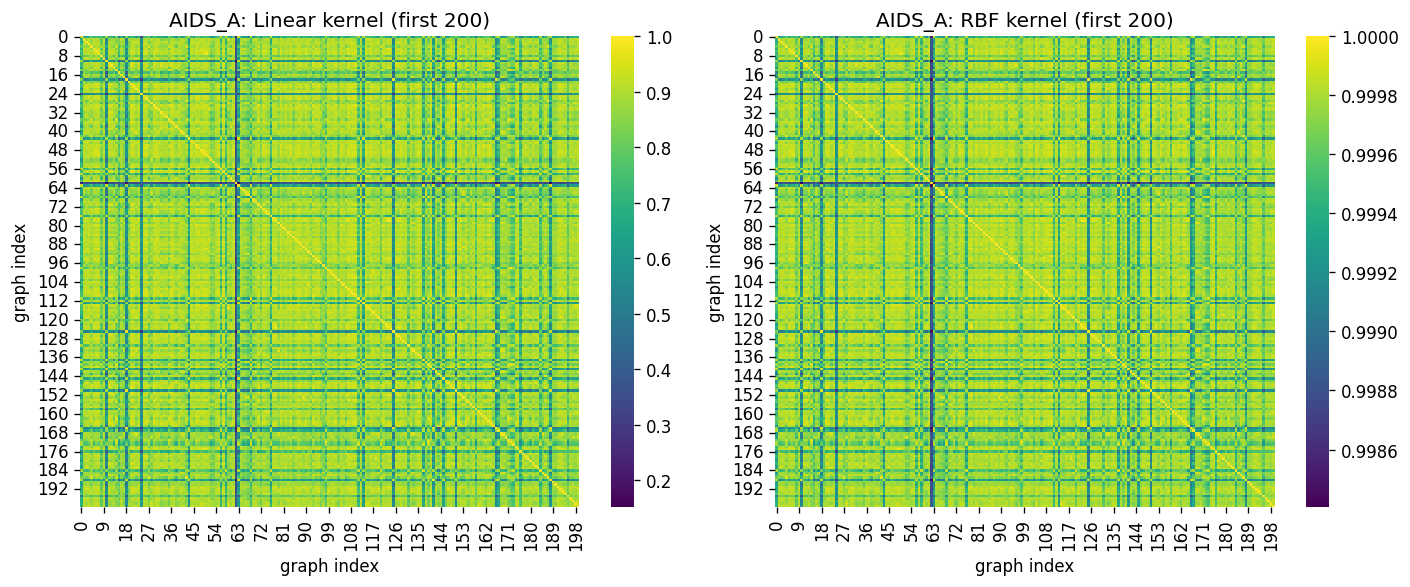

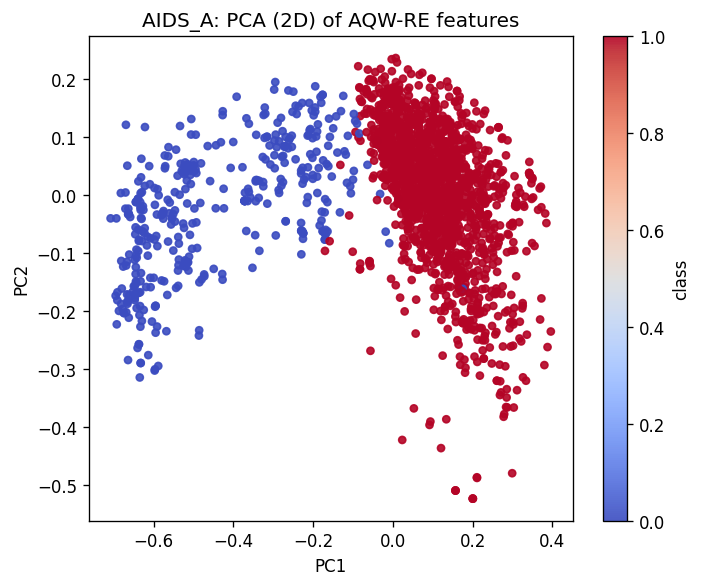

Running t-SNE (this can take a while for large datasets)...


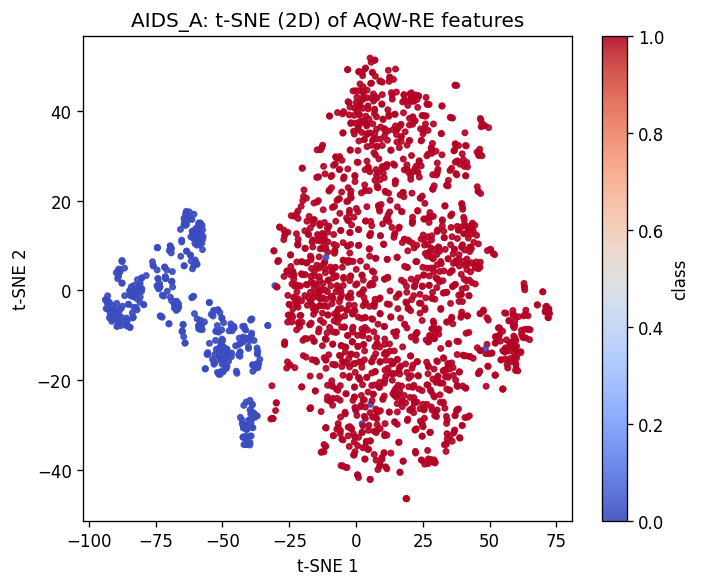

Computing quantum embeddings for 200 samples (n_qubits=6)...


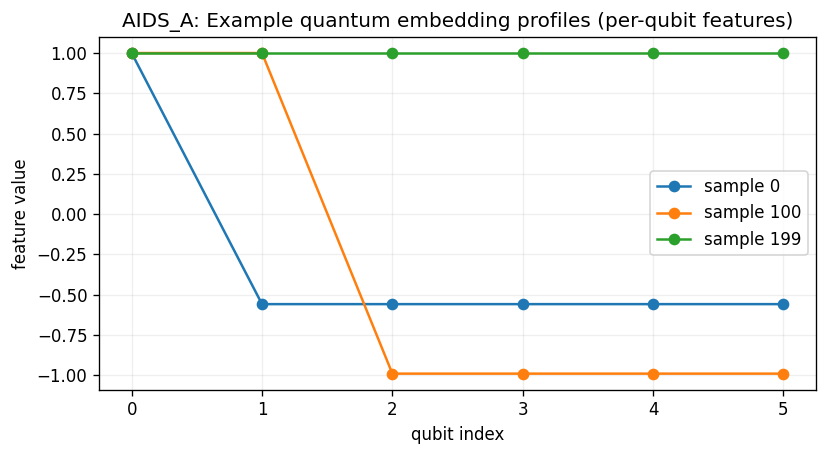

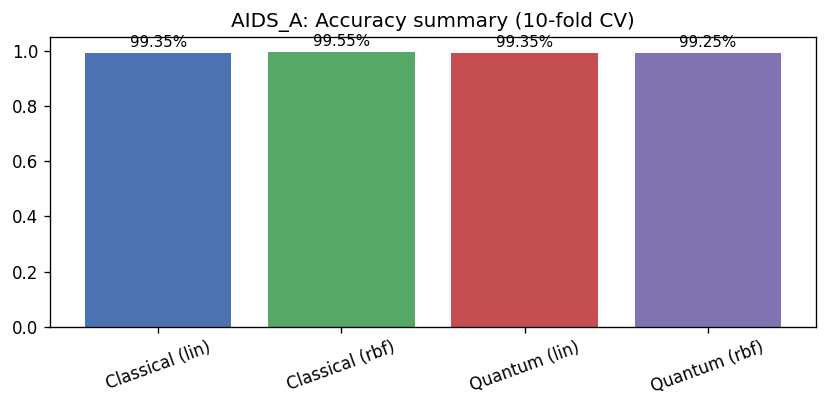

In [ ]:
# ---------- AQW-RE full script (Colab/Jupyter-ready) ----------
# Paste into a cell. Change only the 4 filenames below for each dataset.

# ---------- (UNCOMMENT ON FIRST RUN) install deps ----------
!pip install --quiet networkx pandas scikit-learn tqdm
!pip install --quiet "quri-parts[qulacs]"  # optional extras: qulacs bridge if desired

# ---------- Imports ----------
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import hashlib
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- QURI Parts availability ----------
try:
    from quri_parts.circuit import QuantumCircuit
    from quri_parts.core.state import quantum_state, apply_circuit
    try:
        from quri_parts.qulacs.simulator import evaluate_state_to_vector, run_circuit
        _QURI_HAVE_QLACS_BRIDGE = True
    except Exception:
        evaluate_state_to_vector = None
        try:
            from quri_parts.qulacs.simulator import run_circuit
            _QURI_HAVE_QLACS_BRIDGE = True
        except Exception:
            run_circuit = None
            _QURI_HAVE_QLACS_BRIDGE = False
    HAS_QURI = True
except Exception:
    HAS_QURI = False
    _QURI_HAVE_QLACS_BRIDGE = False

print("QURI Parts available:", HAS_QURI, "  QURI->Qulacs bridge:", _QURI_HAVE_QLACS_BRIDGE)

# ========== USER: set dataset files (change per dataset cell) ==========
A_FILE  = "AIDS_A.txt"                        # edge list file (u,v) rows, 1-indexed
GI_FILE = "AIDS_graph_indicator.txt"         # node -> graph id (one integer per node)
GL_FILE = "AIDS_graph_labels.txt"            # graph label per graph
NL_FILE = "AIDS_node_labels.txt"             # node labels (one per node)
# ======================================================================

# Quick file existence check
for f in (A_FILE, GI_FILE, GL_FILE, NL_FILE):
    print(f"{f:40s} exists: {os.path.exists(f)}")

# ---------- Load data (robust pandas usage) ----------
edges = pd.read_csv(A_FILE, header=None, sep=",", engine="python").values.astype(int)
graph_indicator = pd.read_csv(GI_FILE, header=None).iloc[:, 0].values
graph_labels = pd.read_csv(GL_FILE, header=None).iloc[:, 0].values
node_labels = pd.read_csv(NL_FILE, header=None).iloc[:, 0].values

n_nodes = len(graph_indicator)
node_to_graph = {i+1: int(graph_indicator[i]) for i in range(n_nodes)}
n_graphs = int(len(graph_labels))
graphs = {gid: nx.Graph() for gid in range(1, n_graphs+1)}

# Add nodes
for node_idx in range(1, n_nodes+1):
    gid = node_to_graph[node_idx]
    lab = node_labels[node_idx-1] if node_idx-1 < len(node_labels) else 0
    graphs[gid].add_node(node_idx, label=str(lab))

# Add edges (skip edges that cross graphs)
for u, v in edges:
    u = int(u); v = int(v)
    if node_to_graph.get(u, -1) != node_to_graph.get(v, -2):
        continue
    graphs[node_to_graph[u]].add_edge(u, v)

graph_list = [graphs[gid] for gid in range(1, n_graphs+1)]
y = np.array(graph_labels, dtype=int)

print(f"\nLoaded {len(graph_list)} graphs. Example sizes:")
for i, G in enumerate(graph_list[:5]):
    print(f" G#{i+1}: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
print()

# ---------- AQW-RE component functions ----------

def wl_modified_counts(G, h=3):
    labels = {n: str(G.nodes[n].get("label", str(G.degree[n]))) for n in G.nodes()}
    counter = {}
    for lab in labels.values():
        counter["v0_"+lab] = counter.get("v0_"+lab, 0) + 1
    for it in range(1, h+1):
        new_labels = {}
        for n in G.nodes():
            neigh_labs = sorted([labels[nb] for nb in G.neighbors(n)])
            deg_pattern = [0,0,0,0]
            for nb in G.neighbors(n):
                d = G.degree[nb]
                if d == 1: deg_pattern[0]+=1
                elif d == 2: deg_pattern[1]+=1
                elif d == 3: deg_pattern[2]+=1
                else: deg_pattern[3]+=1
            deg_pattern_str = "dpat:" + ",".join(map(str,deg_pattern))
            long_lab = labels[n] + "|" + "|".join(neigh_labs) + "|" + deg_pattern_str
            lab_hash = hashlib.sha1((f"v{it}_" + long_lab).encode()).hexdigest()
            new_labels[n] = lab_hash
            key = f"v{it}_{lab_hash[:16]}"
            counter[key] = counter.get(key, 0) + 1
        labels = new_labels
    return counter

def wl_counter_to_vector(counter, n_bits=1024, n_hash_rounds=2):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def effective_resistance_stats(G, sample_limit=300):
    n = G.number_of_nodes()
    if n <= 1:
        return np.array([0.0, 0.0])
    L = nx.laplacian_matrix(G).astype(float).toarray()
    L_pinv = np.linalg.pinv(L)
    m = min(sample_limit, n*(n-1)//2)
    resistances = []
    if m == n*(n-1)//2:
        for i_idx in range(n):
            for j_idx in range(i_idx+1, n):
                r = L_pinv[i_idx, i_idx] + L_pinv[j_idx, j_idx] - 2*L_pinv[i_idx, j_idx]
                resistances.append(r)
    else:
        rng = np.random.default_rng(42)
        sampled = set()
        while len(sampled) < m:
            i_idx = int(rng.integers(0, n)); j_idx = int(rng.integers(0, n))
            if i_idx == j_idx: continue
            a,b = min(i_idx, j_idx), max(i_idx, j_idx)
            if (a,b) in sampled: continue
            sampled.add((a,b))
            r = L_pinv[a,a] + L_pinv[b,b] - 2*L_pinv[a,b]
            resistances.append(r)
    resistances = np.array(resistances)
    if resistances.size == 0:
        return np.array([0.0, 0.0])
    mean_r = np.mean(resistances); std_r = np.std(resistances)
    return np.array([mean_r / (n+1e-12), std_r / (n+1e-12)])

def spectral_moments(G, k=6):
    if G.number_of_nodes() == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    if len(evals) >= k:
        return np.real(evals[:k])
    else:
        out = np.zeros(k); out[:len(evals)] = evals; return out

def ctqw_signature(G, times=(0.05, 0.2, 0.8), r_eig=20):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(len(times)*4)
    L = nx.laplacian_matrix(G).astype(float).toarray()
    try:
        evals, evecs = np.linalg.eigh(L)
    except Exception:
        evals, evecs = np.linalg.eig(L); evals = np.real(evals); evecs = np.real(evecs)
    r = min(r_eig, n)
    idx = np.argsort(evals)[:r]
    lam = evals[idx]; vecs = evecs[:, idx]
    feats = []
    for t in times:
        phases = np.exp(-1j * lam * t)
        U_approx = (vecs * phases) @ vecs.T
        probs = np.abs(U_approx)**2
        row_mean = probs.mean(axis=1)
        feats.append(row_mean.mean())
        feats.append(row_mean.std())
        feats.append(probs.mean())
        feats.append(np.trace(probs)/max(1,n))
    return np.array(feats)

def adaptive_entanglement_descriptor(G, k=8):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    topk = evals[:k] if len(evals) >= k else np.concatenate([evals, np.zeros(k-len(evals))])
    topk = np.array(topk, dtype=float)
    if np.linalg.norm(topk) > 0:
        topk = topk / (np.linalg.norm(topk)+1e-12)
    return topk

def degree_pattern_vector(G):
    deg_counts = [0,0,0,0,0]
    for n in G.nodes():
        d = G.degree[n]
        if d == 0: deg_counts[0]+=1
        elif d == 1: deg_counts[1]+=1
        elif d == 2: deg_counts[2]+=1
        elif d == 3: deg_counts[3]+=1
        else: deg_counts[4]+=1
    deg_counts = np.array(deg_counts, dtype=float)
    deg_counts = deg_counts / (deg_counts.sum() + 1e-12)
    label_counter = {}
    for n in G.nodes():
        lab = str(G.nodes[n].get("label", "0"))
        label_counter[lab] = label_counter.get(lab, 0) + 1
    K = 8
    buckets = np.zeros(K, dtype=float)
    for lab, cnt in label_counter.items():
        idx = int(hashlib.md5(lab.encode()).hexdigest(), 16) % K
        buckets[idx] += cnt
    if buckets.sum() > 0:
        buckets = buckets / buckets.sum()
    return np.concatenate([deg_counts, buckets])

def hash_counter_to_vector(counter, n_bits=2048, n_hash_rounds=3):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def aqw_re_feature(G):
    wl_counter = wl_modified_counts(G, h=3)
    wl_vec = wl_counter_to_vector(wl_counter, n_bits=1024, n_hash_rounds=2)
    ct = ctqw_signature(G, times=(0.05,0.2,0.8), r_eig=20)
    er = effective_resistance_stats(G, sample_limit=300)
    spec = spectral_moments(G, k=6)
    deg = degree_pattern_vector(G)
    aed = adaptive_entanglement_descriptor(G, k=6)
    feat = np.concatenate([wl_vec, ct, er, spec, deg, aed])
    if np.linalg.norm(feat) > 0:
        feat = feat / (np.linalg.norm(feat) + 1e-12)
    return feat

# ---------- Compute features ----------
print("Computing AQW-RE features for all graphs...")
FEATURES = []
for G in tqdm(graph_list):
    FEATURES.append(aqw_re_feature(G))
X = np.vstack(FEATURES)
print("Feature matrix shape:", X.shape)

# ---------- Evaluation helpers (no PCA leakage) ----------
PCA_DIM = 120
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_macro': make_scorer(f1_score, average='macro')}

def evaluate_and_report_classical(X_feat, y, kernels=("linear","rbf")):
    results = {}
    for kernel in kernels:
        pipe = make_pipeline(PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42),
                             SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42))
        cv_res = cross_validate(pipe, X_feat, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
        acc_mean = np.mean(cv_res['test_accuracy']); acc_std = np.std(cv_res['test_accuracy'])
        f1_mean = np.mean(cv_res['test_f1_macro']); f1_std = np.std(cv_res['test_f1_macro'])
        results[kernel] = {'accuracy': (acc_mean, acc_std), 'f1_macro': (f1_mean, f1_std), 'cv_details': cv_res}
        print(f"Kernel={kernel:6s} | Acc={acc_mean:.4f} ± {acc_std:.4f} | F1-macro={f1_mean:.4f} ± {f1_std:.4f}")
    return results

# ---------- QURI Parts quantum embedding (replacement for the Qulacs routine) ----------
def quantum_embedding_features_quri(X_in, n_qubits=15):
    if not HAS_QURI:
        raise RuntimeError("QURI Parts (quri-parts) not available. Install quri-parts and extras if needed.")
    X = np.array(X_in, dtype=float)
    if X.shape[1] < n_qubits:
        X_pad = np.hstack([X, np.zeros((X.shape[0], n_qubits - X.shape[1]))])
    else:
        X_pad = X[:, :n_qubits]
    mins = X_pad.min(axis=0); maxs = X_pad.max(axis=0)
    ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
    X_angles = 2 * np.pi * (X_pad - mins) / ranges
    n_samples = X_angles.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)
    dim = 1 << n_qubits
    idxs = np.arange(dim, dtype=np.uint32)
    bit_masks = [((idxs >> q) & 1).astype(np.uint8) for q in range(n_qubits)]

    for i in range(n_samples):
        angles = X_angles[i]
        circ = QuantumCircuit(n_qubits)
        for q in range(n_qubits):
            circ.add_RY_gate(q, float(angles[q]))
        for q in range(n_qubits - 1):
            circ.add_CNOT_gate(q, q + 1)
        state = quantum_state(n_qubits)
        state = apply_circuit(circ, state)
        if 'evaluate_state_to_vector' in globals() and evaluate_state_to_vector is not None:
            vec = evaluate_state_to_vector(state).vector
        elif 'run_circuit' in globals() and run_circuit is not None:
            init_vec = np.zeros(1 << n_qubits, dtype=complex); init_vec[0] = 1.0
            out = run_circuit(circ, init_vec)
            vec = out if isinstance(out, np.ndarray) else getattr(out, "vector", np.asarray(out))
        else:
            try:
                vec = state.vector
            except Exception as e:
                raise RuntimeError("Could not extract state vector from QURI Parts state; "
                                   "install quri-parts[qulacs] or update quri-parts.") from e
        probs = np.abs(vec)**2
        for q in range(n_qubits):
            bm = bit_masks[q]
            features[i, q] = float(np.dot(probs, 1.0 - 2.0 * bm))

    return features

def evaluate_and_report_quantum(X_feat, y, kernels=("linear","rbf"), n_qubits=6):
    if not HAS_QURI:
        print("[QURI Parts not available] skipping quantum evaluation."); return None
    accs = {k: [] for k in kernels}
    f1s = {k: [] for k in kernels}
    for train_idx, test_idx in cv.split(X_feat, y):
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        pca = PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42)
        Xtr_red = pca.fit_transform(X_train); Xte_red = pca.transform(X_test)
        qtr = quantum_embedding_features_quri(Xtr_red, n_qubits=n_qubits)
        qte = quantum_embedding_features_quri(Xte_red, n_qubits=n_qubits)
        Xtr_cat = np.hstack([Xtr_red, qtr]); Xte_cat = np.hstack([Xte_red, qte])
        for kernel in kernels:
            clf = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
            clf.fit(Xtr_cat, y_train)
            y_pred = clf.predict(Xte_cat)
            accs[kernel].append(accuracy_score(y_test, y_pred))
            f1s[kernel].append(f1_score(y_test, y_pred, average='macro'))
    results = {}
    for kernel in kernels:
        results[kernel] = {'accuracy': (np.mean(accs[kernel]), np.std(accs[kernel])),
                           'f1_macro': (np.mean(f1s[kernel]), np.std(f1s[kernel])),
                           'fold_accs': accs[kernel], 'fold_f1s': f1s[kernel]}
        print(f"(quantum) Kernel={kernel:6s} | Acc={results[kernel]['accuracy'][0]:.4f} ± {results[kernel]['accuracy'][1]:.4f} | "
              f"F1-macro={results[kernel]['f1_macro'][0]:.4f} ± {results[kernel]['f1_macro'][1]:.4f}")
    return results

# ---------- Run classical evaluation ----------
print("\n=== Classical SVM on AQW-RE features (PCA inside CV) ===")
classical_results = evaluate_and_report_classical(X, y, kernels=("linear","rbf"))

# ---------- Optionally run quantum-inspired evaluation (per-fold PCA) ----------
USE_QUANTUM = HAS_QURI and True
if USE_QUANTUM:
    print(f"\n=== Quantum-inspired per-fold embedding (via QURI Parts) ===")
    quantum_results = evaluate_and_report_quantum(X, y, kernels=("linear","rbf"), n_qubits=6)
else:
    quantum_results = None

# ---------- Summary ----------
print("\n" + "#"*60)
print("Summary (classical):")
for k, v in classical_results.items():
    acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
    print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

if quantum_results:
    print("\nSummary (quantum-inspired):")
    for k, v in quantum_results.items():
        acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
        print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

print("\nDone. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).")

# ---------- Quick unit test to check QURI embedding (small) ----------
if HAS_QURI:
    try:
        print("\nRunning tiny QURI embedding test...")
        small_X = np.random.randn(3, 10)  # 3 samples, 10 dims
        qfeat = quantum_embedding_features_quri(small_X, n_qubits=4)
        print("quri embedding shape:", qfeat.shape)
        print(qfeat)
    except Exception as e:
        print("QURI embedding test failed:", str(e))
else:
    print("Skipping QURI embedding test because quri-parts is not available.")



# ----------------- Visualization-----------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

plt.rcParams.update({"figure.dpi": 120})
dataset_name = os.path.splitext(A_FILE)[0] if 'A_FILE' in globals() else "dataset"

n = X.shape[0]
# choose subset for kernel heatmaps (keeps execution & plots readable)
subset_n = min(200, n)
subset_idx = np.arange(subset_n)

# --- 1) Kernel heatmaps (linear & RBF on subset) ---
K_lin = linear_kernel(X[subset_idx])
K_rbf = rbf_kernel(X[subset_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(K_lin, ax=axes[0], cmap="viridis")
axes[0].set_title(f"{dataset_name}: Linear kernel (first {subset_n})")
axes[0].set_xlabel("graph index"); axes[0].set_ylabel("graph index")

sns.heatmap(K_rbf, ax=axes[1], cmap="viridis")
axes[1].set_title(f"{dataset_name}: RBF kernel (first {subset_n})")
axes[1].set_xlabel("graph index"); axes[1].set_ylabel("graph index")

plt.tight_layout()
plt.show()

# --- 2) PCA 2D scatter of full X ---
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
plt.figure(figsize=(6,5))
sc = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, s=18, cmap="coolwarm", alpha=0.9)
plt.title(f"{dataset_name}: PCA (2D) of AQW-RE features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, label="class")
plt.tight_layout()
plt.show()

# --- 3) t-SNE (only when manageable) ---
if n <= 2000:
    print("Running t-SNE (this can take a while for large datasets)...")
    tsne = TSNE(n_components=2, init='pca', random_state=42, learning_rate='auto', perplexity=30)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=10, cmap="coolwarm", alpha=0.9)
    plt.title(f"{dataset_name}: t-SNE (2D) of AQW-RE features")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.colorbar(label="class")
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping t-SNE for {dataset_name} (n={n} > 2000).")

# --- 4) Quantum embedding feature examples (if QURI available) ---
try:
    if HAS_QURI and 'quantum_embedding_features_quri' in globals():
        # pick a small n_qubits for visualization (use same value as evaluation if set)
        vis_n_qubits = 6 if 'n_qubits' not in globals() else int(n_qubits)
        vis_n_qubits = min(vis_n_qubits, X.shape[1])  # don't exceed feature dim
        # compute on a small subset to save time if dataset large
        q_subset = min(200, n)
        print(f"Computing quantum embeddings for {q_subset} samples (n_qubits={vis_n_qubits})...")
        X_for_q = X[:q_subset]
        q_emb = quantum_embedding_features_quri(X_for_q, n_qubits=vis_n_qubits)
        # show 3 example profiles
        ex_idx = [0, q_subset//2, q_subset-1] if q_subset>=3 else list(range(q_subset))
        plt.figure(figsize=(7,3 + len(ex_idx)*0.3))
        for i, idx in enumerate(ex_idx):
            plt.plot(q_emb[idx], marker='o', label=f"sample {idx}")
        plt.title(f"{dataset_name}: Example quantum embedding profiles (per-qubit features)")
        plt.xlabel("qubit index"); plt.ylabel("feature value")
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print("QURI Parts not available or quantum function missing — skipping quantum plots.")
except Exception as e:
    print("Quantum embedding plotting failed (skipping). Error:", e)

# --- 5) Accuracy summary bar chart (classical_results & quantum_results) ---
def _get_acc(res_dict, key):
    try:
        return res_dict.get(key, {}).get('accuracy', (np.nan, np.nan))[0]
    except Exception:
        return np.nan

cls_lin = _get_acc(classical_results, 'linear') if 'classical_results' in globals() else np.nan
cls_rbf = _get_acc(classical_results, 'rbf') if 'classical_results' in globals() else np.nan
q_lin = _get_acc(quantum_results, 'linear') if 'quantum_results' in globals() and quantum_results else np.nan
q_rbf = _get_acc(quantum_results, 'rbf') if 'quantum_results' in globals() and quantum_results else np.nan

labels = []
vals = []
if not np.isnan(cls_lin):
    labels.append('Classical (lin)'); vals.append(cls_lin)
if not np.isnan(cls_rbf):
    labels.append('Classical (rbf)'); vals.append(cls_rbf)
if not np.isnan(q_lin):
    labels.append('Quantum (lin)'); vals.append(q_lin)
if not np.isnan(q_rbf):
    labels.append('Quantum (rbf)'); vals.append(q_rbf)

if len(labels) > 0:
    x = np.arange(len(labels))
    plt.figure(figsize=(7,3.5))
    bars = plt.bar(x, vals, color=['#4C72B0','#55A868','#C44E52','#8172B2'][:len(labels)])
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=9)
    plt.ylim(0, 1.05)
    plt.xticks(x, labels, rotation=20)
    plt.title(f"{dataset_name}: Accuracy summary (10-fold CV)")
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy results found to plot summary.")

# ----------------- End visualization cell -----------------



#**MUTAG**

QURI Parts available: True   QURI->Qulacs bridge: True
MUTAG_A.txt                              exists: True
MUTAG_graph_indicator.txt                exists: True
MUTAG_graph_labels.txt                   exists: True
MUTAG_node_labels.txt                    exists: True

Loaded 188 graphs. Example sizes:
 G#1: nodes=17, edges=19
 G#2: nodes=13, edges=14
 G#3: nodes=13, edges=14
 G#4: nodes=19, edges=22
 G#5: nodes=11, edges=11

Computing AQW-RE features for all graphs...


100%|██████████| 188/188 [00:01<00:00, 147.21it/s]


Feature matrix shape: (188, 1063)

=== Classical SVM on AQW-RE features (PCA inside CV) ===
Kernel=linear | Acc=0.7982 ± 0.0603 | F1-macro=0.7484 ± 0.0763
Kernel=rbf    | Acc=0.8675 ± 0.0532 | F1-macro=0.8531 ± 0.0584

=== Quantum-inspired per-fold embedding (via QURI Parts) ===
(quantum) Kernel=linear | Acc=0.7933 ± 0.0627 | F1-macro=0.7496 ± 0.0786
(quantum) Kernel=rbf    | Acc=0.8038 ± 0.0565 | F1-macro=0.7504 ± 0.0806

############################################################
Summary (classical):
 linear -> accuracy=0.7982 ± 0.0603, f1_macro=0.7484 ± 0.0763
 rbf    -> accuracy=0.8675 ± 0.0532, f1_macro=0.8531 ± 0.0584

Summary (quantum-inspired):
 linear -> accuracy=0.7933 ± 0.0627, f1_macro=0.7496 ± 0.0786
 rbf    -> accuracy=0.8038 ± 0.0565, f1_macro=0.7504 ± 0.0806

Done. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).

Running tiny QURI embedding test...
quri embedding shape: (3, 4)
[[ 1.          1.          1.         -0.637

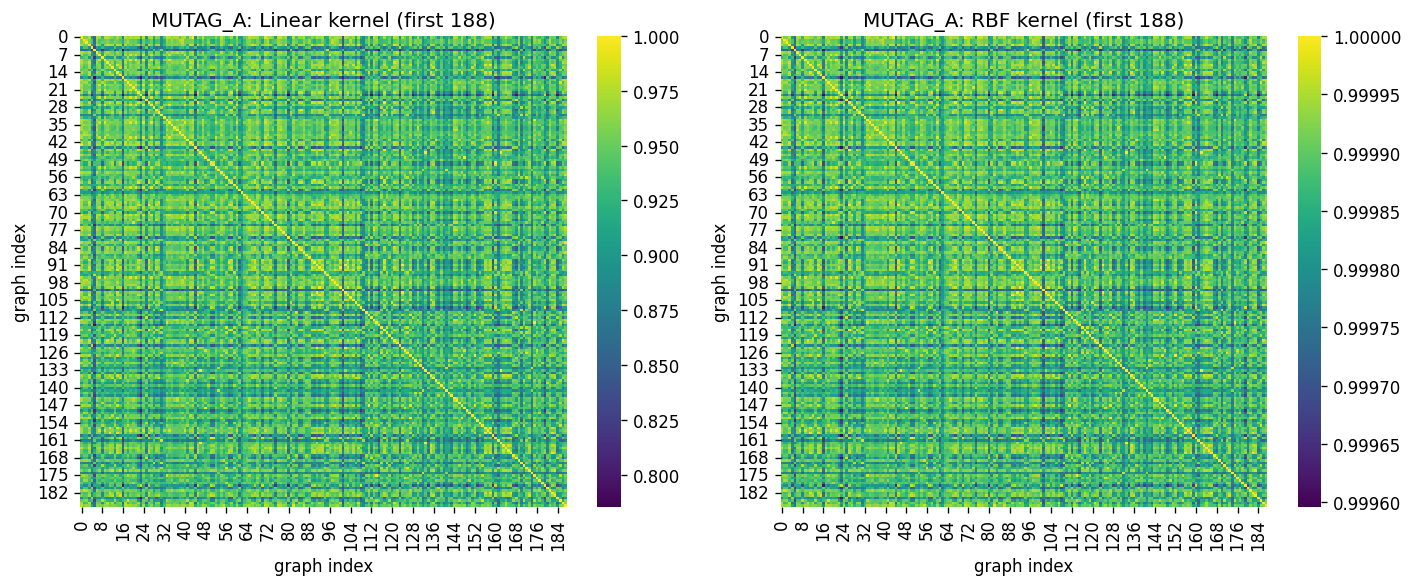

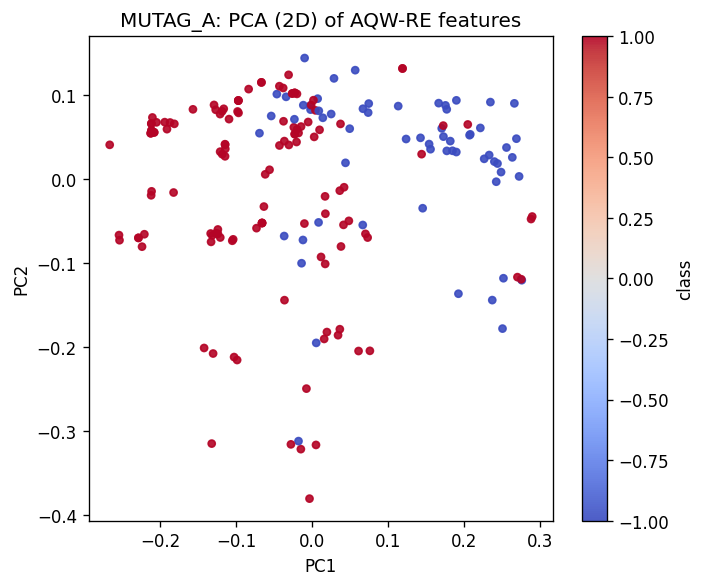

Running t-SNE (this can take a while for large datasets)...


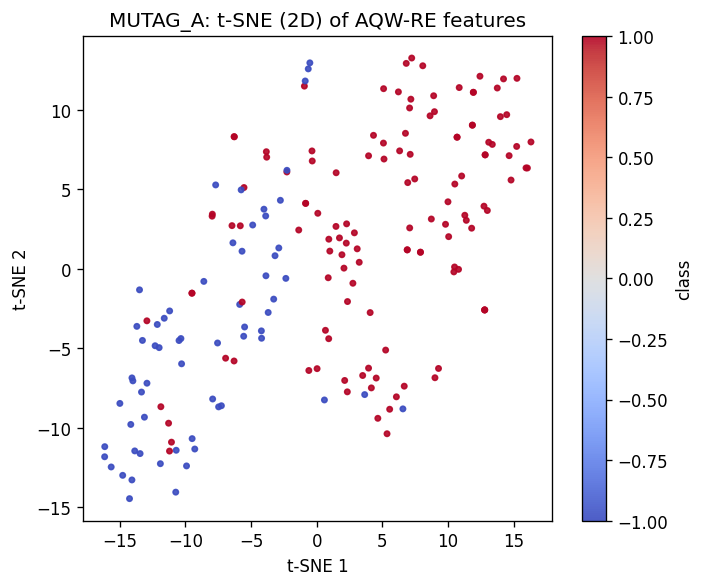

Computing quantum embeddings for 188 samples (n_qubits=6)...


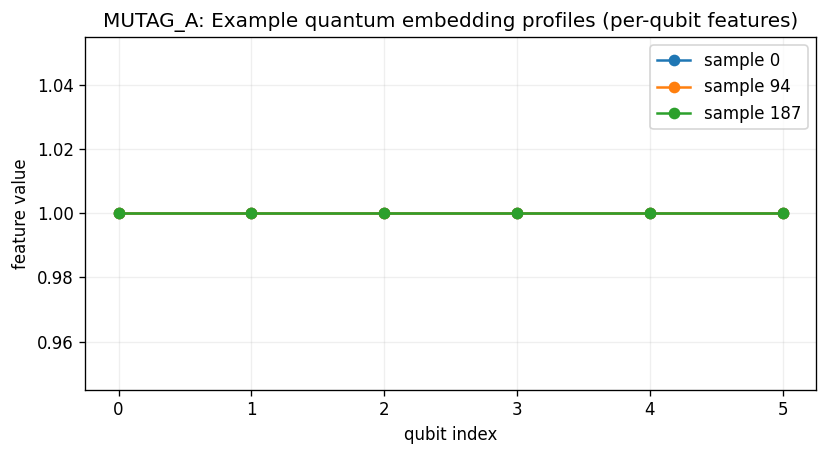

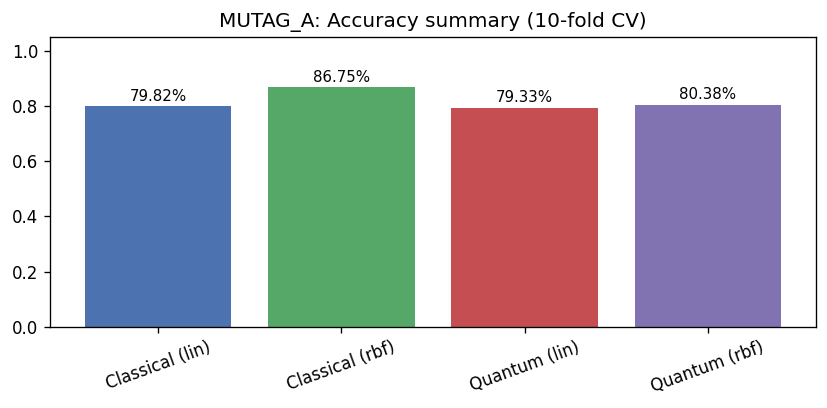

In [ ]:
# ---------- AQW-RE full script (Colab/Jupyter-ready) ----------
# Paste into a cell. Change only the 4 filenames below for each dataset.

# ---------- (UNCOMMENT ON FIRST RUN) install deps ----------
!pip install --quiet networkx pandas scikit-learn tqdm
!pip install --quiet "quri-parts[qulacs]"  # optional extras: qulacs bridge if desired

# ---------- Imports ----------
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import hashlib
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- QURI Parts availability ----------
try:
    from quri_parts.circuit import QuantumCircuit
    from quri_parts.core.state import quantum_state, apply_circuit
    try:
        from quri_parts.qulacs.simulator import evaluate_state_to_vector, run_circuit
        _QURI_HAVE_QLACS_BRIDGE = True
    except Exception:
        evaluate_state_to_vector = None
        try:
            from quri_parts.qulacs.simulator import run_circuit
            _QURI_HAVE_QLACS_BRIDGE = True
        except Exception:
            run_circuit = None
            _QURI_HAVE_QLACS_BRIDGE = False
    HAS_QURI = True
except Exception:
    HAS_QURI = False
    _QURI_HAVE_QLACS_BRIDGE = False

print("QURI Parts available:", HAS_QURI, "  QURI->Qulacs bridge:", _QURI_HAVE_QLACS_BRIDGE)

# ========== USER: set dataset files (change per dataset cell) ==========
A_FILE  = "MUTAG_A.txt"                        # edge list file (u,v) rows, 1-indexed
GI_FILE = "MUTAG_graph_indicator.txt"         # node -> graph id (one integer per node)
GL_FILE = "MUTAG_graph_labels.txt"            # graph label per graph
NL_FILE = "MUTAG_node_labels.txt"             # node labels (one per node)
# ======================================================================

# Quick file existence check
for f in (A_FILE, GI_FILE, GL_FILE, NL_FILE):
    print(f"{f:40s} exists: {os.path.exists(f)}")

# ---------- Load data (robust pandas usage) ----------
edges = pd.read_csv(A_FILE, header=None, sep=",", engine="python").values.astype(int)
graph_indicator = pd.read_csv(GI_FILE, header=None).iloc[:, 0].values
graph_labels = pd.read_csv(GL_FILE, header=None).iloc[:, 0].values
node_labels = pd.read_csv(NL_FILE, header=None).iloc[:, 0].values

n_nodes = len(graph_indicator)
node_to_graph = {i+1: int(graph_indicator[i]) for i in range(n_nodes)}
n_graphs = int(len(graph_labels))
graphs = {gid: nx.Graph() for gid in range(1, n_graphs+1)}

# Add nodes
for node_idx in range(1, n_nodes+1):
    gid = node_to_graph[node_idx]
    lab = node_labels[node_idx-1] if node_idx-1 < len(node_labels) else 0
    graphs[gid].add_node(node_idx, label=str(lab))

# Add edges (skip edges that cross graphs)
for u, v in edges:
    u = int(u); v = int(v)
    if node_to_graph.get(u, -1) != node_to_graph.get(v, -2):
        continue
    graphs[node_to_graph[u]].add_edge(u, v)

graph_list = [graphs[gid] for gid in range(1, n_graphs+1)]
y = np.array(graph_labels, dtype=int)

print(f"\nLoaded {len(graph_list)} graphs. Example sizes:")
for i, G in enumerate(graph_list[:5]):
    print(f" G#{i+1}: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
print()

# ---------- AQW-RE component functions ----------

def wl_modified_counts(G, h=3):
    labels = {n: str(G.nodes[n].get("label", str(G.degree[n]))) for n in G.nodes()}
    counter = {}
    for lab in labels.values():
        counter["v0_"+lab] = counter.get("v0_"+lab, 0) + 1
    for it in range(1, h+1):
        new_labels = {}
        for n in G.nodes():
            neigh_labs = sorted([labels[nb] for nb in G.neighbors(n)])
            deg_pattern = [0,0,0,0]
            for nb in G.neighbors(n):
                d = G.degree[nb]
                if d == 1: deg_pattern[0]+=1
                elif d == 2: deg_pattern[1]+=1
                elif d == 3: deg_pattern[2]+=1
                else: deg_pattern[3]+=1
            deg_pattern_str = "dpat:" + ",".join(map(str,deg_pattern))
            long_lab = labels[n] + "|" + "|".join(neigh_labs) + "|" + deg_pattern_str
            lab_hash = hashlib.sha1((f"v{it}_" + long_lab).encode()).hexdigest()
            new_labels[n] = lab_hash
            key = f"v{it}_{lab_hash[:16]}"
            counter[key] = counter.get(key, 0) + 1
        labels = new_labels
    return counter

def wl_counter_to_vector(counter, n_bits=1024, n_hash_rounds=2):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def effective_resistance_stats(G, sample_limit=300):
    n = G.number_of_nodes()
    if n <= 1:
        return np.array([0.0, 0.0])
    L = nx.laplacian_matrix(G).astype(float).toarray()
    L_pinv = np.linalg.pinv(L)
    m = min(sample_limit, n*(n-1)//2)
    resistances = []
    if m == n*(n-1)//2:
        for i_idx in range(n):
            for j_idx in range(i_idx+1, n):
                r = L_pinv[i_idx, i_idx] + L_pinv[j_idx, j_idx] - 2*L_pinv[i_idx, j_idx]
                resistances.append(r)
    else:
        rng = np.random.default_rng(42)
        sampled = set()
        while len(sampled) < m:
            i_idx = int(rng.integers(0, n)); j_idx = int(rng.integers(0, n))
            if i_idx == j_idx: continue
            a,b = min(i_idx, j_idx), max(i_idx, j_idx)
            if (a,b) in sampled: continue
            sampled.add((a,b))
            r = L_pinv[a,a] + L_pinv[b,b] - 2*L_pinv[a,b]
            resistances.append(r)
    resistances = np.array(resistances)
    if resistances.size == 0:
        return np.array([0.0, 0.0])
    mean_r = np.mean(resistances); std_r = np.std(resistances)
    return np.array([mean_r / (n+1e-12), std_r / (n+1e-12)])

def spectral_moments(G, k=6):
    if G.number_of_nodes() == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    if len(evals) >= k:
        return np.real(evals[:k])
    else:
        out = np.zeros(k); out[:len(evals)] = evals; return out

def ctqw_signature(G, times=(0.05, 0.2, 0.8), r_eig=20):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(len(times)*4)
    L = nx.laplacian_matrix(G).astype(float).toarray()
    try:
        evals, evecs = np.linalg.eigh(L)
    except Exception:
        evals, evecs = np.linalg.eig(L); evals = np.real(evals); evecs = np.real(evecs)
    r = min(r_eig, n)
    idx = np.argsort(evals)[:r]
    lam = evals[idx]; vecs = evecs[:, idx]
    feats = []
    for t in times:
        phases = np.exp(-1j * lam * t)
        U_approx = (vecs * phases) @ vecs.T
        probs = np.abs(U_approx)**2
        row_mean = probs.mean(axis=1)
        feats.append(row_mean.mean())
        feats.append(row_mean.std())
        feats.append(probs.mean())
        feats.append(np.trace(probs)/max(1,n))
    return np.array(feats)

def adaptive_entanglement_descriptor(G, k=8):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    topk = evals[:k] if len(evals) >= k else np.concatenate([evals, np.zeros(k-len(evals))])
    topk = np.array(topk, dtype=float)
    if np.linalg.norm(topk) > 0:
        topk = topk / (np.linalg.norm(topk)+1e-12)
    return topk

def degree_pattern_vector(G):
    deg_counts = [0,0,0,0,0]
    for n in G.nodes():
        d = G.degree[n]
        if d == 0: deg_counts[0]+=1
        elif d == 1: deg_counts[1]+=1
        elif d == 2: deg_counts[2]+=1
        elif d == 3: deg_counts[3]+=1
        else: deg_counts[4]+=1
    deg_counts = np.array(deg_counts, dtype=float)
    deg_counts = deg_counts / (deg_counts.sum() + 1e-12)
    label_counter = {}
    for n in G.nodes():
        lab = str(G.nodes[n].get("label", "0"))
        label_counter[lab] = label_counter.get(lab, 0) + 1
    K = 8
    buckets = np.zeros(K, dtype=float)
    for lab, cnt in label_counter.items():
        idx = int(hashlib.md5(lab.encode()).hexdigest(), 16) % K
        buckets[idx] += cnt
    if buckets.sum() > 0:
        buckets = buckets / buckets.sum()
    return np.concatenate([deg_counts, buckets])

def hash_counter_to_vector(counter, n_bits=2048, n_hash_rounds=3):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def aqw_re_feature(G):
    wl_counter = wl_modified_counts(G, h=3)
    wl_vec = wl_counter_to_vector(wl_counter, n_bits=1024, n_hash_rounds=2)
    ct = ctqw_signature(G, times=(0.05,0.2,0.8), r_eig=20)
    er = effective_resistance_stats(G, sample_limit=300)
    spec = spectral_moments(G, k=6)
    deg = degree_pattern_vector(G)
    aed = adaptive_entanglement_descriptor(G, k=6)
    feat = np.concatenate([wl_vec, ct, er, spec, deg, aed])
    if np.linalg.norm(feat) > 0:
        feat = feat / (np.linalg.norm(feat) + 1e-12)
    return feat

# ---------- Compute features ----------
print("Computing AQW-RE features for all graphs...")
FEATURES = []
for G in tqdm(graph_list):
    FEATURES.append(aqw_re_feature(G))
X = np.vstack(FEATURES)
print("Feature matrix shape:", X.shape)

# ---------- Evaluation helpers (no PCA leakage) ----------
PCA_DIM = 120
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_macro': make_scorer(f1_score, average='macro')}

def evaluate_and_report_classical(X_feat, y, kernels=("linear","rbf")):
    results = {}
    for kernel in kernels:
        pipe = make_pipeline(PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42),
                             SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42))
        cv_res = cross_validate(pipe, X_feat, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
        acc_mean = np.mean(cv_res['test_accuracy']); acc_std = np.std(cv_res['test_accuracy'])
        f1_mean = np.mean(cv_res['test_f1_macro']); f1_std = np.std(cv_res['test_f1_macro'])
        results[kernel] = {'accuracy': (acc_mean, acc_std), 'f1_macro': (f1_mean, f1_std), 'cv_details': cv_res}
        print(f"Kernel={kernel:6s} | Acc={acc_mean:.4f} ± {acc_std:.4f} | F1-macro={f1_mean:.4f} ± {f1_std:.4f}")
    return results

# ---------- QURI Parts quantum embedding (replacement for the Qulacs routine) ----------
def quantum_embedding_features_quri(X_in, n_qubits=15):
    if not HAS_QURI:
        raise RuntimeError("QURI Parts (quri-parts) not available. Install quri-parts and extras if needed.")
    X = np.array(X_in, dtype=float)
    if X.shape[1] < n_qubits:
        X_pad = np.hstack([X, np.zeros((X.shape[0], n_qubits - X.shape[1]))])
    else:
        X_pad = X[:, :n_qubits]
    mins = X_pad.min(axis=0); maxs = X_pad.max(axis=0)
    ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
    X_angles = 2 * np.pi * (X_pad - mins) / ranges
    n_samples = X_angles.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)
    dim = 1 << n_qubits
    idxs = np.arange(dim, dtype=np.uint32)
    bit_masks = [((idxs >> q) & 1).astype(np.uint8) for q in range(n_qubits)]

    for i in range(n_samples):
        angles = X_angles[i]
        circ = QuantumCircuit(n_qubits)
        for q in range(n_qubits):
            circ.add_RY_gate(q, float(angles[q]))
        for q in range(n_qubits - 1):
            circ.add_CNOT_gate(q, q + 1)
        state = quantum_state(n_qubits)
        state = apply_circuit(circ, state)
        if 'evaluate_state_to_vector' in globals() and evaluate_state_to_vector is not None:
            vec = evaluate_state_to_vector(state).vector
        elif 'run_circuit' in globals() and run_circuit is not None:
            init_vec = np.zeros(1 << n_qubits, dtype=complex); init_vec[0] = 1.0
            out = run_circuit(circ, init_vec)
            vec = out if isinstance(out, np.ndarray) else getattr(out, "vector", np.asarray(out))
        else:
            try:
                vec = state.vector
            except Exception as e:
                raise RuntimeError("Could not extract state vector from QURI Parts state; "
                                   "install quri-parts[qulacs] or update quri-parts.") from e
        probs = np.abs(vec)**2
        for q in range(n_qubits):
            bm = bit_masks[q]
            features[i, q] = float(np.dot(probs, 1.0 - 2.0 * bm))

    return features

def evaluate_and_report_quantum(X_feat, y, kernels=("linear","rbf"), n_qubits=6):
    if not HAS_QURI:
        print("[QURI Parts not available] skipping quantum evaluation."); return None
    accs = {k: [] for k in kernels}
    f1s = {k: [] for k in kernels}
    for train_idx, test_idx in cv.split(X_feat, y):
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        pca = PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42)
        Xtr_red = pca.fit_transform(X_train); Xte_red = pca.transform(X_test)
        qtr = quantum_embedding_features_quri(Xtr_red, n_qubits=n_qubits)
        qte = quantum_embedding_features_quri(Xte_red, n_qubits=n_qubits)
        Xtr_cat = np.hstack([Xtr_red, qtr]); Xte_cat = np.hstack([Xte_red, qte])
        for kernel in kernels:
            clf = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
            clf.fit(Xtr_cat, y_train)
            y_pred = clf.predict(Xte_cat)
            accs[kernel].append(accuracy_score(y_test, y_pred))
            f1s[kernel].append(f1_score(y_test, y_pred, average='macro'))
    results = {}
    for kernel in kernels:
        results[kernel] = {'accuracy': (np.mean(accs[kernel]), np.std(accs[kernel])),
                           'f1_macro': (np.mean(f1s[kernel]), np.std(f1s[kernel])),
                           'fold_accs': accs[kernel], 'fold_f1s': f1s[kernel]}
        print(f"(quantum) Kernel={kernel:6s} | Acc={results[kernel]['accuracy'][0]:.4f} ± {results[kernel]['accuracy'][1]:.4f} | "
              f"F1-macro={results[kernel]['f1_macro'][0]:.4f} ± {results[kernel]['f1_macro'][1]:.4f}")
    return results

# ---------- Run classical evaluation ----------
print("\n=== Classical SVM on AQW-RE features (PCA inside CV) ===")
classical_results = evaluate_and_report_classical(X, y, kernels=("linear","rbf"))

# ---------- Optionally run quantum-inspired evaluation (per-fold PCA) ----------
USE_QUANTUM = HAS_QURI and True
if USE_QUANTUM:
    print(f"\n=== Quantum-inspired per-fold embedding (via QURI Parts) ===")
    quantum_results = evaluate_and_report_quantum(X, y, kernels=("linear","rbf"), n_qubits=6)
else:
    quantum_results = None

# ---------- Summary ----------
print("\n" + "#"*60)
print("Summary (classical):")
for k, v in classical_results.items():
    acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
    print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

if quantum_results:
    print("\nSummary (quantum-inspired):")
    for k, v in quantum_results.items():
        acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
        print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

print("\nDone. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).")

# ---------- Quick unit test to check QURI embedding (small) ----------
if HAS_QURI:
    try:
        print("\nRunning tiny QURI embedding test...")
        small_X = np.random.randn(3, 10)  # 3 samples, 10 dims
        qfeat = quantum_embedding_features_quri(small_X, n_qubits=4)
        print("quri embedding shape:", qfeat.shape)
        print(qfeat)
    except Exception as e:
        print("QURI embedding test failed:", str(e))
else:
    print("Skipping QURI embedding test because quri-parts is not available.")


# ----------------- Visualization-----------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

plt.rcParams.update({"figure.dpi": 120})
dataset_name = os.path.splitext(A_FILE)[0] if 'A_FILE' in globals() else "dataset"

n = X.shape[0]
# choose subset for kernel heatmaps (keeps execution & plots readable)
subset_n = min(200, n)
subset_idx = np.arange(subset_n)

# --- 1) Kernel heatmaps (linear & RBF on subset) ---
K_lin = linear_kernel(X[subset_idx])
K_rbf = rbf_kernel(X[subset_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(K_lin, ax=axes[0], cmap="viridis")
axes[0].set_title(f"{dataset_name}: Linear kernel (first {subset_n})")
axes[0].set_xlabel("graph index"); axes[0].set_ylabel("graph index")

sns.heatmap(K_rbf, ax=axes[1], cmap="viridis")
axes[1].set_title(f"{dataset_name}: RBF kernel (first {subset_n})")
axes[1].set_xlabel("graph index"); axes[1].set_ylabel("graph index")

plt.tight_layout()
plt.show()

# --- 2) PCA 2D scatter of full X ---
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
plt.figure(figsize=(6,5))
sc = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, s=18, cmap="coolwarm", alpha=0.9)
plt.title(f"{dataset_name}: PCA (2D) of AQW-RE features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, label="class")
plt.tight_layout()
plt.show()

# --- 3) t-SNE (only when manageable) ---
if n <= 2000:
    print("Running t-SNE (this can take a while for large datasets)...")
    tsne = TSNE(n_components=2, init='pca', random_state=42, learning_rate='auto', perplexity=30)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=10, cmap="coolwarm", alpha=0.9)
    plt.title(f"{dataset_name}: t-SNE (2D) of AQW-RE features")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.colorbar(label="class")
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping t-SNE for {dataset_name} (n={n} > 2000).")

# --- 4) Quantum embedding feature examples (if QURI available) ---
try:
    if HAS_QURI and 'quantum_embedding_features_quri' in globals():
        # pick a small n_qubits for visualization (use same value as evaluation if set)
        vis_n_qubits = 6 if 'n_qubits' not in globals() else int(n_qubits)
        vis_n_qubits = min(vis_n_qubits, X.shape[1])  # don't exceed feature dim
        # compute on a small subset to save time if dataset large
        q_subset = min(200, n)
        print(f"Computing quantum embeddings for {q_subset} samples (n_qubits={vis_n_qubits})...")
        X_for_q = X[:q_subset]
        q_emb = quantum_embedding_features_quri(X_for_q, n_qubits=vis_n_qubits)
        # show 3 example profiles
        ex_idx = [0, q_subset//2, q_subset-1] if q_subset>=3 else list(range(q_subset))
        plt.figure(figsize=(7,3 + len(ex_idx)*0.3))
        for i, idx in enumerate(ex_idx):
            plt.plot(q_emb[idx], marker='o', label=f"sample {idx}")
        plt.title(f"{dataset_name}: Example quantum embedding profiles (per-qubit features)")
        plt.xlabel("qubit index"); plt.ylabel("feature value")
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print("QURI Parts not available or quantum function missing — skipping quantum plots.")
except Exception as e:
    print("Quantum embedding plotting failed (skipping). Error:", e)

# --- 5) Accuracy summary bar chart (classical_results & quantum_results) ---
def _get_acc(res_dict, key):
    try:
        return res_dict.get(key, {}).get('accuracy', (np.nan, np.nan))[0]
    except Exception:
        return np.nan

cls_lin = _get_acc(classical_results, 'linear') if 'classical_results' in globals() else np.nan
cls_rbf = _get_acc(classical_results, 'rbf') if 'classical_results' in globals() else np.nan
q_lin = _get_acc(quantum_results, 'linear') if 'quantum_results' in globals() and quantum_results else np.nan
q_rbf = _get_acc(quantum_results, 'rbf') if 'quantum_results' in globals() and quantum_results else np.nan

labels = []
vals = []
if not np.isnan(cls_lin):
    labels.append('Classical (lin)'); vals.append(cls_lin)
if not np.isnan(cls_rbf):
    labels.append('Classical (rbf)'); vals.append(cls_rbf)
if not np.isnan(q_lin):
    labels.append('Quantum (lin)'); vals.append(q_lin)
if not np.isnan(q_rbf):
    labels.append('Quantum (rbf)'); vals.append(q_rbf)

if len(labels) > 0:
    x = np.arange(len(labels))
    plt.figure(figsize=(7,3.5))
    bars = plt.bar(x, vals, color=['#4C72B0','#55A868','#C44E52','#8172B2'][:len(labels)])
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=9)
    plt.ylim(0, 1.05)
    plt.xticks(x, labels, rotation=20)
    plt.title(f"{dataset_name}: Accuracy summary (10-fold CV)")
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy results found to plot summary.")

# ----------------- End visualization cell -----------------


#**PROTEINS**

QURI Parts available: True   QURI->Qulacs bridge: True
PROTEINS_A.txt                           exists: True
PROTEINS_graph_indicator.txt             exists: True
PROTEINS_graph_labels.txt                exists: True
PROTEINS_node_labels.txt                 exists: True

Loaded 1113 graphs. Example sizes:
 G#1: nodes=42, edges=81
 G#2: nodes=27, edges=46
 G#3: nodes=10, edges=17
 G#4: nodes=24, edges=46
 G#5: nodes=11, edges=21

Computing AQW-RE features for all graphs...


100%|██████████| 1113/1113 [00:28<00:00, 38.81it/s] 


Feature matrix shape: (1113, 1063)

=== Classical SVM on AQW-RE features (PCA inside CV) ===
Kernel=linear | Acc=0.7449 ± 0.0327 | F1-macro=0.7230 ± 0.0380
Kernel=rbf    | Acc=0.7538 ± 0.0230 | F1-macro=0.7373 ± 0.0240

=== Quantum-inspired per-fold embedding (via QURI Parts) ===
(quantum) Kernel=linear | Acc=0.7476 ± 0.0385 | F1-macro=0.7361 ± 0.0388
(quantum) Kernel=rbf    | Acc=0.7404 ± 0.0409 | F1-macro=0.7277 ± 0.0428

############################################################
Summary (classical):
 linear -> accuracy=0.7449 ± 0.0327, f1_macro=0.7230 ± 0.0380
 rbf    -> accuracy=0.7538 ± 0.0230, f1_macro=0.7373 ± 0.0240

Summary (quantum-inspired):
 linear -> accuracy=0.7476 ± 0.0385, f1_macro=0.7361 ± 0.0388
 rbf    -> accuracy=0.7404 ± 0.0409, f1_macro=0.7277 ± 0.0428

Done. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).

Running tiny QURI embedding test...
quri embedding shape: (3, 4)
[[ 1.          1.          1.         -0.70

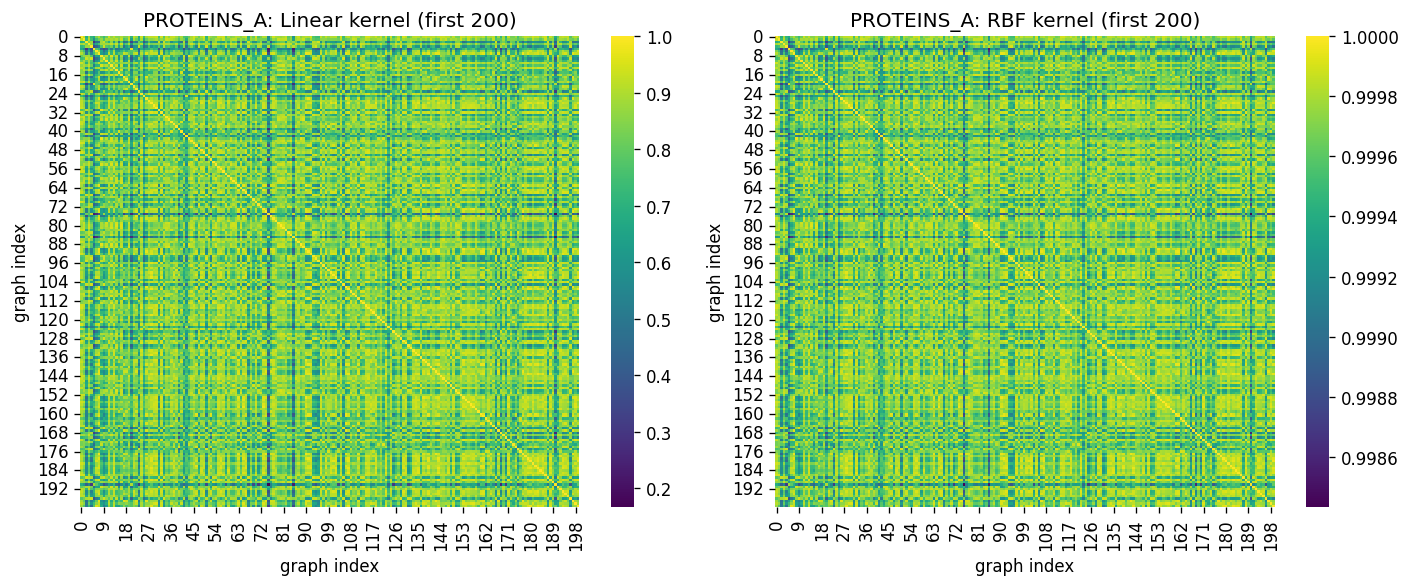

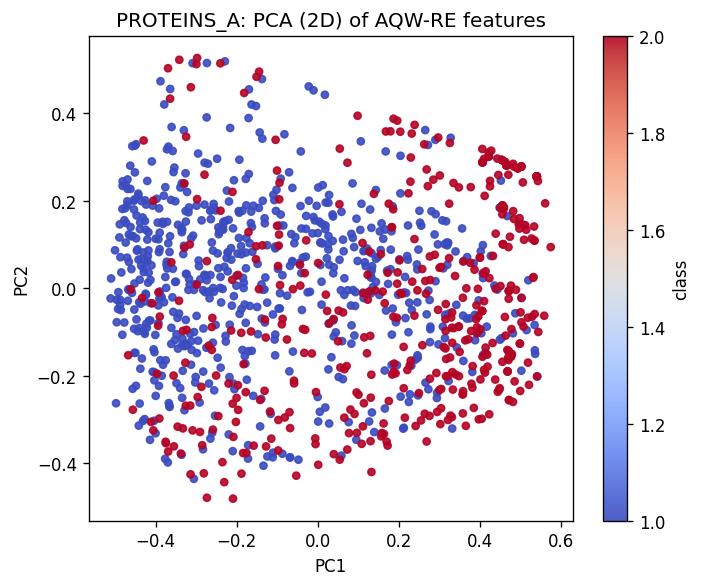

Running t-SNE (this can take a while for large datasets)...


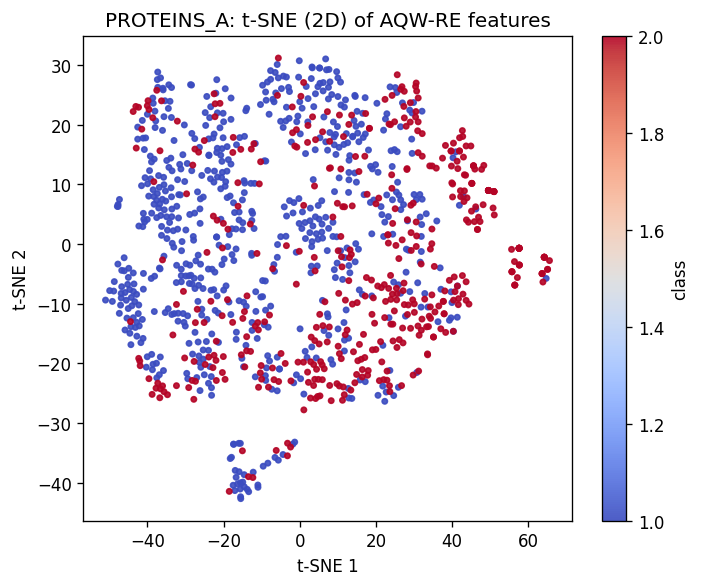

Computing quantum embeddings for 200 samples (n_qubits=6)...


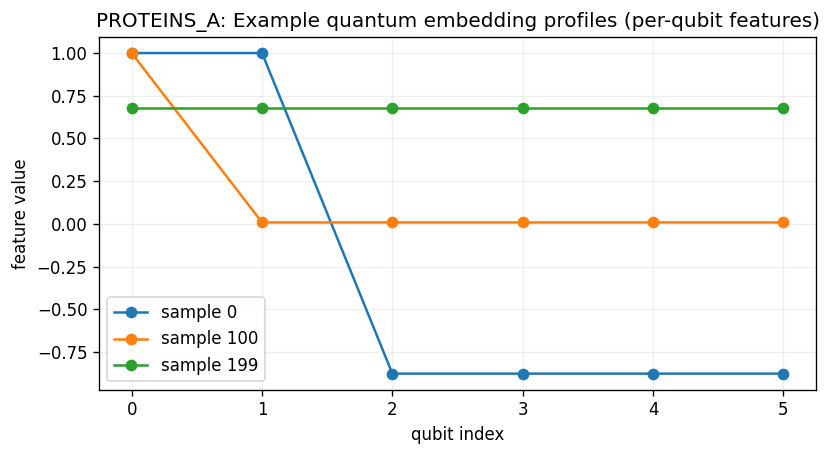

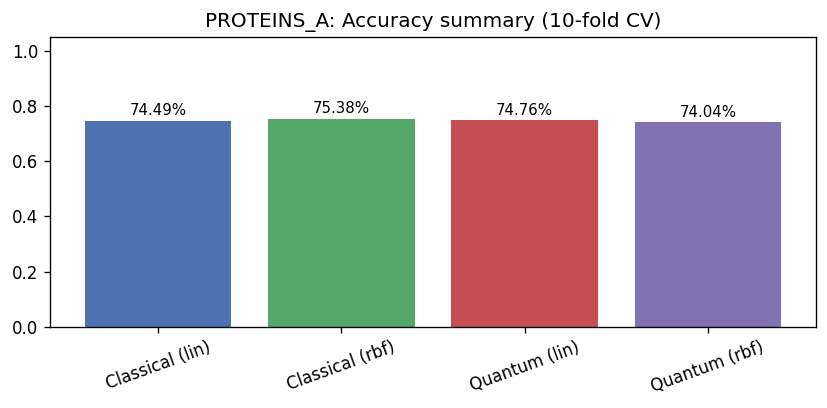

In [ ]:
# ---------- AQW-RE full script (Colab/Jupyter-ready) ----------
# Paste into a cell. Change only the 4 filenames below for each dataset.

# ---------- (UNCOMMENT ON FIRST RUN) install deps ----------
!pip install --quiet networkx pandas scikit-learn tqdm
!pip install --quiet "quri-parts[qulacs]"  # optional extras: qulacs bridge if desired

# ---------- Imports ----------
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import hashlib
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- QURI Parts availability ----------
try:
    from quri_parts.circuit import QuantumCircuit
    from quri_parts.core.state import quantum_state, apply_circuit
    try:
        from quri_parts.qulacs.simulator import evaluate_state_to_vector, run_circuit
        _QURI_HAVE_QLACS_BRIDGE = True
    except Exception:
        evaluate_state_to_vector = None
        try:
            from quri_parts.qulacs.simulator import run_circuit
            _QURI_HAVE_QLACS_BRIDGE = True
        except Exception:
            run_circuit = None
            _QURI_HAVE_QLACS_BRIDGE = False
    HAS_QURI = True
except Exception:
    HAS_QURI = False
    _QURI_HAVE_QLACS_BRIDGE = False

print("QURI Parts available:", HAS_QURI, "  QURI->Qulacs bridge:", _QURI_HAVE_QLACS_BRIDGE)

# ========== USER: set dataset files (change per dataset cell) ==========
A_FILE  = "PROTEINS_A.txt"                        # edge list file (u,v) rows, 1-indexed
GI_FILE = "PROTEINS_graph_indicator.txt"         # node -> graph id (one integer per node)
GL_FILE = "PROTEINS_graph_labels.txt"            # graph label per graph
NL_FILE = "PROTEINS_node_labels.txt"             # node labels (one per node)
# ======================================================================

# Quick file existence check
for f in (A_FILE, GI_FILE, GL_FILE, NL_FILE):
    print(f"{f:40s} exists: {os.path.exists(f)}")

# ---------- Load data (robust pandas usage) ----------
edges = pd.read_csv(A_FILE, header=None, sep=",", engine="python").values.astype(int)
graph_indicator = pd.read_csv(GI_FILE, header=None).iloc[:, 0].values
graph_labels = pd.read_csv(GL_FILE, header=None).iloc[:, 0].values
node_labels = pd.read_csv(NL_FILE, header=None).iloc[:, 0].values

n_nodes = len(graph_indicator)
node_to_graph = {i+1: int(graph_indicator[i]) for i in range(n_nodes)}
n_graphs = int(len(graph_labels))
graphs = {gid: nx.Graph() for gid in range(1, n_graphs+1)}

# Add nodes
for node_idx in range(1, n_nodes+1):
    gid = node_to_graph[node_idx]
    lab = node_labels[node_idx-1] if node_idx-1 < len(node_labels) else 0
    graphs[gid].add_node(node_idx, label=str(lab))

# Add edges (skip edges that cross graphs)
for u, v in edges:
    u = int(u); v = int(v)
    if node_to_graph.get(u, -1) != node_to_graph.get(v, -2):
        continue
    graphs[node_to_graph[u]].add_edge(u, v)

graph_list = [graphs[gid] for gid in range(1, n_graphs+1)]
y = np.array(graph_labels, dtype=int)

print(f"\nLoaded {len(graph_list)} graphs. Example sizes:")
for i, G in enumerate(graph_list[:5]):
    print(f" G#{i+1}: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
print()

# ---------- AQW-RE component functions ----------

def wl_modified_counts(G, h=3):
    labels = {n: str(G.nodes[n].get("label", str(G.degree[n]))) for n in G.nodes()}
    counter = {}
    for lab in labels.values():
        counter["v0_"+lab] = counter.get("v0_"+lab, 0) + 1
    for it in range(1, h+1):
        new_labels = {}
        for n in G.nodes():
            neigh_labs = sorted([labels[nb] for nb in G.neighbors(n)])
            deg_pattern = [0,0,0,0]
            for nb in G.neighbors(n):
                d = G.degree[nb]
                if d == 1: deg_pattern[0]+=1
                elif d == 2: deg_pattern[1]+=1
                elif d == 3: deg_pattern[2]+=1
                else: deg_pattern[3]+=1
            deg_pattern_str = "dpat:" + ",".join(map(str,deg_pattern))
            long_lab = labels[n] + "|" + "|".join(neigh_labs) + "|" + deg_pattern_str
            lab_hash = hashlib.sha1((f"v{it}_" + long_lab).encode()).hexdigest()
            new_labels[n] = lab_hash
            key = f"v{it}_{lab_hash[:16]}"
            counter[key] = counter.get(key, 0) + 1
        labels = new_labels
    return counter

def wl_counter_to_vector(counter, n_bits=1024, n_hash_rounds=2):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def effective_resistance_stats(G, sample_limit=300):
    n = G.number_of_nodes()
    if n <= 1:
        return np.array([0.0, 0.0])
    L = nx.laplacian_matrix(G).astype(float).toarray()
    L_pinv = np.linalg.pinv(L)
    m = min(sample_limit, n*(n-1)//2)
    resistances = []
    if m == n*(n-1)//2:
        for i_idx in range(n):
            for j_idx in range(i_idx+1, n):
                r = L_pinv[i_idx, i_idx] + L_pinv[j_idx, j_idx] - 2*L_pinv[i_idx, j_idx]
                resistances.append(r)
    else:
        rng = np.random.default_rng(42)
        sampled = set()
        while len(sampled) < m:
            i_idx = int(rng.integers(0, n)); j_idx = int(rng.integers(0, n))
            if i_idx == j_idx: continue
            a,b = min(i_idx, j_idx), max(i_idx, j_idx)
            if (a,b) in sampled: continue
            sampled.add((a,b))
            r = L_pinv[a,a] + L_pinv[b,b] - 2*L_pinv[a,b]
            resistances.append(r)
    resistances = np.array(resistances)
    if resistances.size == 0:
        return np.array([0.0, 0.0])
    mean_r = np.mean(resistances); std_r = np.std(resistances)
    return np.array([mean_r / (n+1e-12), std_r / (n+1e-12)])

def spectral_moments(G, k=6):
    if G.number_of_nodes() == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    if len(evals) >= k:
        return np.real(evals[:k])
    else:
        out = np.zeros(k); out[:len(evals)] = evals; return out

def ctqw_signature(G, times=(0.05, 0.2, 0.8), r_eig=20):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(len(times)*4)
    L = nx.laplacian_matrix(G).astype(float).toarray()
    try:
        evals, evecs = np.linalg.eigh(L)
    except Exception:
        evals, evecs = np.linalg.eig(L); evals = np.real(evals); evecs = np.real(evecs)
    r = min(r_eig, n)
    idx = np.argsort(evals)[:r]
    lam = evals[idx]; vecs = evecs[:, idx]
    feats = []
    for t in times:
        phases = np.exp(-1j * lam * t)
        U_approx = (vecs * phases) @ vecs.T
        probs = np.abs(U_approx)**2
        row_mean = probs.mean(axis=1)
        feats.append(row_mean.mean())
        feats.append(row_mean.std())
        feats.append(probs.mean())
        feats.append(np.trace(probs)/max(1,n))
    return np.array(feats)

def adaptive_entanglement_descriptor(G, k=8):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    topk = evals[:k] if len(evals) >= k else np.concatenate([evals, np.zeros(k-len(evals))])
    topk = np.array(topk, dtype=float)
    if np.linalg.norm(topk) > 0:
        topk = topk / (np.linalg.norm(topk)+1e-12)
    return topk

def degree_pattern_vector(G):
    deg_counts = [0,0,0,0,0]
    for n in G.nodes():
        d = G.degree[n]
        if d == 0: deg_counts[0]+=1
        elif d == 1: deg_counts[1]+=1
        elif d == 2: deg_counts[2]+=1
        elif d == 3: deg_counts[3]+=1
        else: deg_counts[4]+=1
    deg_counts = np.array(deg_counts, dtype=float)
    deg_counts = deg_counts / (deg_counts.sum() + 1e-12)
    label_counter = {}
    for n in G.nodes():
        lab = str(G.nodes[n].get("label", "0"))
        label_counter[lab] = label_counter.get(lab, 0) + 1
    K = 8
    buckets = np.zeros(K, dtype=float)
    for lab, cnt in label_counter.items():
        idx = int(hashlib.md5(lab.encode()).hexdigest(), 16) % K
        buckets[idx] += cnt
    if buckets.sum() > 0:
        buckets = buckets / buckets.sum()
    return np.concatenate([deg_counts, buckets])

def hash_counter_to_vector(counter, n_bits=2048, n_hash_rounds=3):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def aqw_re_feature(G):
    wl_counter = wl_modified_counts(G, h=3)
    wl_vec = wl_counter_to_vector(wl_counter, n_bits=1024, n_hash_rounds=2)
    ct = ctqw_signature(G, times=(0.05,0.2,0.8), r_eig=20)
    er = effective_resistance_stats(G, sample_limit=300)
    spec = spectral_moments(G, k=6)
    deg = degree_pattern_vector(G)
    aed = adaptive_entanglement_descriptor(G, k=6)
    feat = np.concatenate([wl_vec, ct, er, spec, deg, aed])
    if np.linalg.norm(feat) > 0:
        feat = feat / (np.linalg.norm(feat) + 1e-12)
    return feat

# ---------- Compute features ----------
print("Computing AQW-RE features for all graphs...")
FEATURES = []
for G in tqdm(graph_list):
    FEATURES.append(aqw_re_feature(G))
X = np.vstack(FEATURES)
print("Feature matrix shape:", X.shape)

# ---------- Evaluation helpers (no PCA leakage) ----------
PCA_DIM = 120
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_macro': make_scorer(f1_score, average='macro')}

def evaluate_and_report_classical(X_feat, y, kernels=("linear","rbf")):
    results = {}
    for kernel in kernels:
        pipe = make_pipeline(PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42),
                             SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42))
        cv_res = cross_validate(pipe, X_feat, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
        acc_mean = np.mean(cv_res['test_accuracy']); acc_std = np.std(cv_res['test_accuracy'])
        f1_mean = np.mean(cv_res['test_f1_macro']); f1_std = np.std(cv_res['test_f1_macro'])
        results[kernel] = {'accuracy': (acc_mean, acc_std), 'f1_macro': (f1_mean, f1_std), 'cv_details': cv_res}
        print(f"Kernel={kernel:6s} | Acc={acc_mean:.4f} ± {acc_std:.4f} | F1-macro={f1_mean:.4f} ± {f1_std:.4f}")
    return results

# ---------- QURI Parts quantum embedding (replacement for the Qulacs routine) ----------
def quantum_embedding_features_quri(X_in, n_qubits=15):
    if not HAS_QURI:
        raise RuntimeError("QURI Parts (quri-parts) not available. Install quri-parts and extras if needed.")
    X = np.array(X_in, dtype=float)
    if X.shape[1] < n_qubits:
        X_pad = np.hstack([X, np.zeros((X.shape[0], n_qubits - X.shape[1]))])
    else:
        X_pad = X[:, :n_qubits]
    mins = X_pad.min(axis=0); maxs = X_pad.max(axis=0)
    ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
    X_angles = 2 * np.pi * (X_pad - mins) / ranges
    n_samples = X_angles.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)
    dim = 1 << n_qubits
    idxs = np.arange(dim, dtype=np.uint32)
    bit_masks = [((idxs >> q) & 1).astype(np.uint8) for q in range(n_qubits)]

    for i in range(n_samples):
        angles = X_angles[i]
        circ = QuantumCircuit(n_qubits)
        for q in range(n_qubits):
            circ.add_RY_gate(q, float(angles[q]))
        for q in range(n_qubits - 1):
            circ.add_CNOT_gate(q, q + 1)
        state = quantum_state(n_qubits)
        state = apply_circuit(circ, state)
        if 'evaluate_state_to_vector' in globals() and evaluate_state_to_vector is not None:
            vec = evaluate_state_to_vector(state).vector
        elif 'run_circuit' in globals() and run_circuit is not None:
            init_vec = np.zeros(1 << n_qubits, dtype=complex); init_vec[0] = 1.0
            out = run_circuit(circ, init_vec)
            vec = out if isinstance(out, np.ndarray) else getattr(out, "vector", np.asarray(out))
        else:
            try:
                vec = state.vector
            except Exception as e:
                raise RuntimeError("Could not extract state vector from QURI Parts state; "
                                   "install quri-parts[qulacs] or update quri-parts.") from e
        probs = np.abs(vec)**2
        for q in range(n_qubits):
            bm = bit_masks[q]
            features[i, q] = float(np.dot(probs, 1.0 - 2.0 * bm))

    return features

def evaluate_and_report_quantum(X_feat, y, kernels=("linear","rbf"), n_qubits=6):
    if not HAS_QURI:
        print("[QURI Parts not available] skipping quantum evaluation."); return None
    accs = {k: [] for k in kernels}
    f1s = {k: [] for k in kernels}
    for train_idx, test_idx in cv.split(X_feat, y):
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        pca = PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42)
        Xtr_red = pca.fit_transform(X_train); Xte_red = pca.transform(X_test)
        qtr = quantum_embedding_features_quri(Xtr_red, n_qubits=n_qubits)
        qte = quantum_embedding_features_quri(Xte_red, n_qubits=n_qubits)
        Xtr_cat = np.hstack([Xtr_red, qtr]); Xte_cat = np.hstack([Xte_red, qte])
        for kernel in kernels:
            clf = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
            clf.fit(Xtr_cat, y_train)
            y_pred = clf.predict(Xte_cat)
            accs[kernel].append(accuracy_score(y_test, y_pred))
            f1s[kernel].append(f1_score(y_test, y_pred, average='macro'))
    results = {}
    for kernel in kernels:
        results[kernel] = {'accuracy': (np.mean(accs[kernel]), np.std(accs[kernel])),
                           'f1_macro': (np.mean(f1s[kernel]), np.std(f1s[kernel])),
                           'fold_accs': accs[kernel], 'fold_f1s': f1s[kernel]}
        print(f"(quantum) Kernel={kernel:6s} | Acc={results[kernel]['accuracy'][0]:.4f} ± {results[kernel]['accuracy'][1]:.4f} | "
              f"F1-macro={results[kernel]['f1_macro'][0]:.4f} ± {results[kernel]['f1_macro'][1]:.4f}")
    return results

# ---------- Run classical evaluation ----------
print("\n=== Classical SVM on AQW-RE features (PCA inside CV) ===")
classical_results = evaluate_and_report_classical(X, y, kernels=("linear","rbf"))

# ---------- Optionally run quantum-inspired evaluation (per-fold PCA) ----------
USE_QUANTUM = HAS_QURI and True
if USE_QUANTUM:
    print(f"\n=== Quantum-inspired per-fold embedding (via QURI Parts) ===")
    quantum_results = evaluate_and_report_quantum(X, y, kernels=("linear","rbf"), n_qubits=6)
else:
    quantum_results = None

# ---------- Summary ----------
print("\n" + "#"*60)
print("Summary (classical):")
for k, v in classical_results.items():
    acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
    print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

if quantum_results:
    print("\nSummary (quantum-inspired):")
    for k, v in quantum_results.items():
        acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
        print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

print("\nDone. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).")

# ---------- Quick unit test to check QURI embedding (small) ----------
if HAS_QURI:
    try:
        print("\nRunning tiny QURI embedding test...")
        small_X = np.random.randn(3, 10)  # 3 samples, 10 dims
        qfeat = quantum_embedding_features_quri(small_X, n_qubits=4)
        print("quri embedding shape:", qfeat.shape)
        print(qfeat)
    except Exception as e:
        print("QURI embedding test failed:", str(e))
else:
    print("Skipping QURI embedding test because quri-parts is not available.")


# ----------------- Visualization-----------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

plt.rcParams.update({"figure.dpi": 120})
dataset_name = os.path.splitext(A_FILE)[0] if 'A_FILE' in globals() else "dataset"

n = X.shape[0]
# choose subset for kernel heatmaps (keeps execution & plots readable)
subset_n = min(200, n)
subset_idx = np.arange(subset_n)

# --- 1) Kernel heatmaps (linear & RBF on subset) ---
K_lin = linear_kernel(X[subset_idx])
K_rbf = rbf_kernel(X[subset_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(K_lin, ax=axes[0], cmap="viridis")
axes[0].set_title(f"{dataset_name}: Linear kernel (first {subset_n})")
axes[0].set_xlabel("graph index"); axes[0].set_ylabel("graph index")

sns.heatmap(K_rbf, ax=axes[1], cmap="viridis")
axes[1].set_title(f"{dataset_name}: RBF kernel (first {subset_n})")
axes[1].set_xlabel("graph index"); axes[1].set_ylabel("graph index")

plt.tight_layout()
plt.show()

# --- 2) PCA 2D scatter of full X ---
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
plt.figure(figsize=(6,5))
sc = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, s=18, cmap="coolwarm", alpha=0.9)
plt.title(f"{dataset_name}: PCA (2D) of AQW-RE features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, label="class")
plt.tight_layout()
plt.show()

# --- 3) t-SNE (only when manageable) ---
if n <= 2000:
    print("Running t-SNE (this can take a while for large datasets)...")
    tsne = TSNE(n_components=2, init='pca', random_state=42, learning_rate='auto', perplexity=30)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=10, cmap="coolwarm", alpha=0.9)
    plt.title(f"{dataset_name}: t-SNE (2D) of AQW-RE features")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.colorbar(label="class")
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping t-SNE for {dataset_name} (n={n} > 2000).")

# --- 4) Quantum embedding feature examples (if QURI available) ---
try:
    if HAS_QURI and 'quantum_embedding_features_quri' in globals():
        # pick a small n_qubits for visualization (use same value as evaluation if set)
        vis_n_qubits = 6 if 'n_qubits' not in globals() else int(n_qubits)
        vis_n_qubits = min(vis_n_qubits, X.shape[1])  # don't exceed feature dim
        # compute on a small subset to save time if dataset large
        q_subset = min(200, n)
        print(f"Computing quantum embeddings for {q_subset} samples (n_qubits={vis_n_qubits})...")
        X_for_q = X[:q_subset]
        q_emb = quantum_embedding_features_quri(X_for_q, n_qubits=vis_n_qubits)
        # show 3 example profiles
        ex_idx = [0, q_subset//2, q_subset-1] if q_subset>=3 else list(range(q_subset))
        plt.figure(figsize=(7,3 + len(ex_idx)*0.3))
        for i, idx in enumerate(ex_idx):
            plt.plot(q_emb[idx], marker='o', label=f"sample {idx}")
        plt.title(f"{dataset_name}: Example quantum embedding profiles (per-qubit features)")
        plt.xlabel("qubit index"); plt.ylabel("feature value")
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print("QURI Parts not available or quantum function missing — skipping quantum plots.")
except Exception as e:
    print("Quantum embedding plotting failed (skipping). Error:", e)

# --- 5) Accuracy summary bar chart (classical_results & quantum_results) ---
def _get_acc(res_dict, key):
    try:
        return res_dict.get(key, {}).get('accuracy', (np.nan, np.nan))[0]
    except Exception:
        return np.nan

cls_lin = _get_acc(classical_results, 'linear') if 'classical_results' in globals() else np.nan
cls_rbf = _get_acc(classical_results, 'rbf') if 'classical_results' in globals() else np.nan
q_lin = _get_acc(quantum_results, 'linear') if 'quantum_results' in globals() and quantum_results else np.nan
q_rbf = _get_acc(quantum_results, 'rbf') if 'quantum_results' in globals() and quantum_results else np.nan

labels = []
vals = []
if not np.isnan(cls_lin):
    labels.append('Classical (lin)'); vals.append(cls_lin)
if not np.isnan(cls_rbf):
    labels.append('Classical (rbf)'); vals.append(cls_rbf)
if not np.isnan(q_lin):
    labels.append('Quantum (lin)'); vals.append(q_lin)
if not np.isnan(q_rbf):
    labels.append('Quantum (rbf)'); vals.append(q_rbf)

if len(labels) > 0:
    x = np.arange(len(labels))
    plt.figure(figsize=(7,3.5))
    bars = plt.bar(x, vals, color=['#4C72B0','#55A868','#C44E52','#8172B2'][:len(labels)])
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=9)
    plt.ylim(0, 1.05)
    plt.xticks(x, labels, rotation=20)
    plt.title(f"{dataset_name}: Accuracy summary (10-fold CV)")
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy results found to plot summary.")

# ----------------- End visualization cell -----------------


#**PTC_MR**

QURI Parts available: True   QURI->Qulacs bridge: True
PTC_MR_A.txt                             exists: True
PTC_MR_graph_indicator.txt               exists: True
PTC_MR_graph_labels.txt                  exists: True
PTC_MR_node_labels.txt                   exists: True

Loaded 344 graphs. Example sizes:
 G#1: nodes=2, edges=1
 G#2: nodes=4, edges=3
 G#3: nodes=50, edges=49
 G#4: nodes=20, edges=22
 G#5: nodes=16, edges=18

Computing AQW-RE features for all graphs...


100%|██████████| 344/344 [00:02<00:00, 138.68it/s]


Feature matrix shape: (344, 1063)

=== Classical SVM on AQW-RE features (PCA inside CV) ===
Kernel=linear | Acc=0.5700 ± 0.0652 | F1-macro=0.4945 ± 0.0795
Kernel=rbf    | Acc=0.6342 ± 0.0617 | F1-macro=0.6037 ± 0.0680

=== Quantum-inspired per-fold embedding (via QURI Parts) ===
(quantum) Kernel=linear | Acc=0.5929 ± 0.0672 | F1-macro=0.5335 ± 0.0852
(quantum) Kernel=rbf    | Acc=0.5874 ± 0.0744 | F1-macro=0.5221 ± 0.0804

############################################################
Summary (classical):
 linear -> accuracy=0.5700 ± 0.0652, f1_macro=0.4945 ± 0.0795
 rbf    -> accuracy=0.6342 ± 0.0617, f1_macro=0.6037 ± 0.0680

Summary (quantum-inspired):
 linear -> accuracy=0.5929 ± 0.0672, f1_macro=0.5335 ± 0.0852
 rbf    -> accuracy=0.5874 ± 0.0744, f1_macro=0.5221 ± 0.0804

Done. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).

Running tiny QURI embedding test...
quri embedding shape: (3, 4)
[[ 1.          0.79885689  0.79885689  0.798

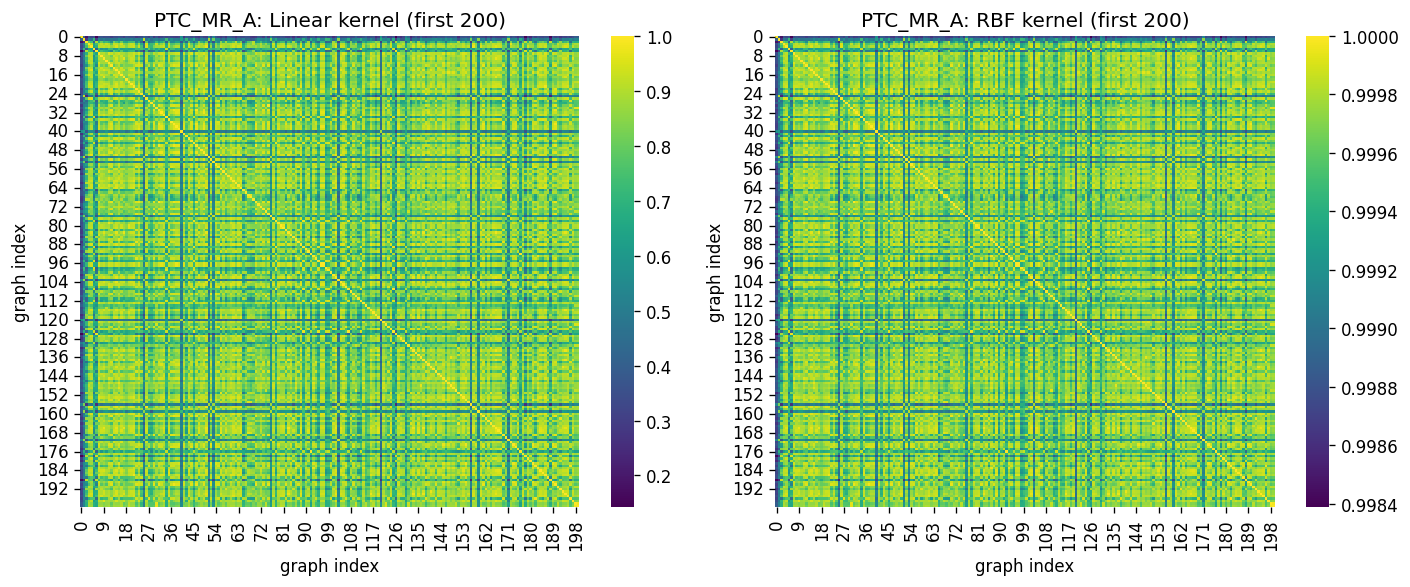

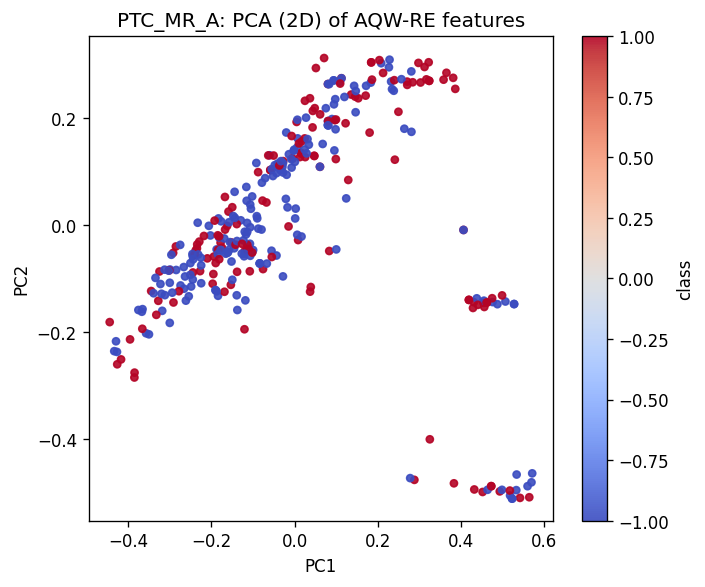

Running t-SNE (this can take a while for large datasets)...


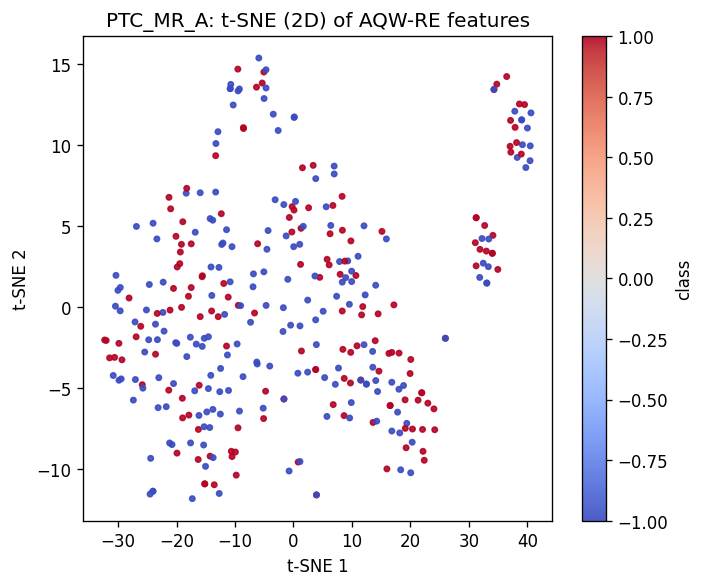

Computing quantum embeddings for 200 samples (n_qubits=6)...


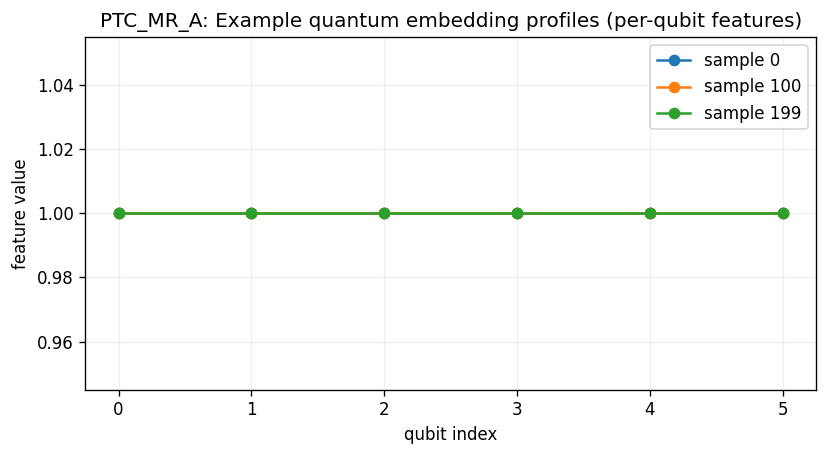

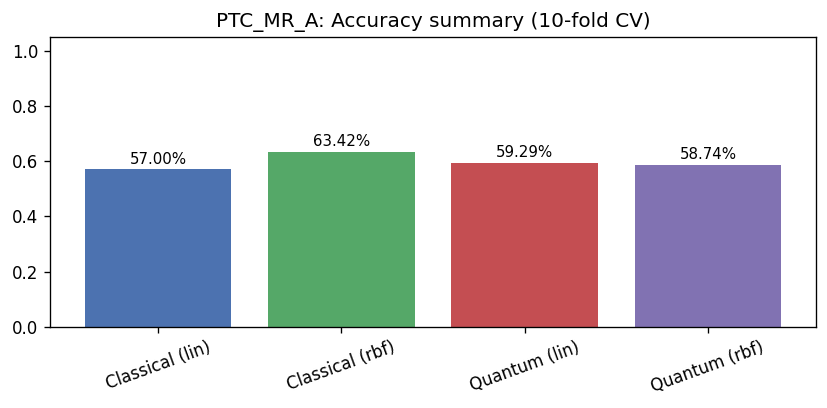

In [ ]:
# ---------- AQW-RE full script (Colab/Jupyter-ready) ----------
# Paste into a cell. Change only the 4 filenames below for each dataset.

# ---------- (UNCOMMENT ON FIRST RUN) install deps ----------
!pip install --quiet networkx pandas scikit-learn tqdm
!pip install --quiet "quri-parts[qulacs]"  # optional extras: qulacs bridge if desired

# ---------- Imports ----------
import os, math
import numpy as np
import pandas as pd
import networkx as nx
import hashlib
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ---------- QURI Parts availability ----------
try:
    from quri_parts.circuit import QuantumCircuit
    from quri_parts.core.state import quantum_state, apply_circuit
    try:
        from quri_parts.qulacs.simulator import evaluate_state_to_vector, run_circuit
        _QURI_HAVE_QLACS_BRIDGE = True
    except Exception:
        evaluate_state_to_vector = None
        try:
            from quri_parts.qulacs.simulator import run_circuit
            _QURI_HAVE_QLACS_BRIDGE = True
        except Exception:
            run_circuit = None
            _QURI_HAVE_QLACS_BRIDGE = False
    HAS_QURI = True
except Exception:
    HAS_QURI = False
    _QURI_HAVE_QLACS_BRIDGE = False

print("QURI Parts available:", HAS_QURI, "  QURI->Qulacs bridge:", _QURI_HAVE_QLACS_BRIDGE)

# ========== USER: set dataset files (change per dataset cell) ==========
A_FILE  = "PTC_MR_A.txt"                        # edge list file (u,v) rows, 1-indexed
GI_FILE = "PTC_MR_graph_indicator.txt"         # node -> graph id (one integer per node)
GL_FILE = "PTC_MR_graph_labels.txt"            # graph label per graph
NL_FILE = "PTC_MR_node_labels.txt"             # node labels (one per node)
# ======================================================================

# Quick file existence check
for f in (A_FILE, GI_FILE, GL_FILE, NL_FILE):
    print(f"{f:40s} exists: {os.path.exists(f)}")

# ---------- Load data (robust pandas usage) ----------
edges = pd.read_csv(A_FILE, header=None, sep=",", engine="python").values.astype(int)
graph_indicator = pd.read_csv(GI_FILE, header=None).iloc[:, 0].values
graph_labels = pd.read_csv(GL_FILE, header=None).iloc[:, 0].values
node_labels = pd.read_csv(NL_FILE, header=None).iloc[:, 0].values

n_nodes = len(graph_indicator)
node_to_graph = {i+1: int(graph_indicator[i]) for i in range(n_nodes)}
n_graphs = int(len(graph_labels))
graphs = {gid: nx.Graph() for gid in range(1, n_graphs+1)}

# Add nodes
for node_idx in range(1, n_nodes+1):
    gid = node_to_graph[node_idx]
    lab = node_labels[node_idx-1] if node_idx-1 < len(node_labels) else 0
    graphs[gid].add_node(node_idx, label=str(lab))

# Add edges (skip edges that cross graphs)
for u, v in edges:
    u = int(u); v = int(v)
    if node_to_graph.get(u, -1) != node_to_graph.get(v, -2):
        continue
    graphs[node_to_graph[u]].add_edge(u, v)

graph_list = [graphs[gid] for gid in range(1, n_graphs+1)]
y = np.array(graph_labels, dtype=int)

print(f"\nLoaded {len(graph_list)} graphs. Example sizes:")
for i, G in enumerate(graph_list[:5]):
    print(f" G#{i+1}: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")
print()

# ---------- AQW-RE component functions ----------

def wl_modified_counts(G, h=3):
    labels = {n: str(G.nodes[n].get("label", str(G.degree[n]))) for n in G.nodes()}
    counter = {}
    for lab in labels.values():
        counter["v0_"+lab] = counter.get("v0_"+lab, 0) + 1
    for it in range(1, h+1):
        new_labels = {}
        for n in G.nodes():
            neigh_labs = sorted([labels[nb] for nb in G.neighbors(n)])
            deg_pattern = [0,0,0,0]
            for nb in G.neighbors(n):
                d = G.degree[nb]
                if d == 1: deg_pattern[0]+=1
                elif d == 2: deg_pattern[1]+=1
                elif d == 3: deg_pattern[2]+=1
                else: deg_pattern[3]+=1
            deg_pattern_str = "dpat:" + ",".join(map(str,deg_pattern))
            long_lab = labels[n] + "|" + "|".join(neigh_labs) + "|" + deg_pattern_str
            lab_hash = hashlib.sha1((f"v{it}_" + long_lab).encode()).hexdigest()
            new_labels[n] = lab_hash
            key = f"v{it}_{lab_hash[:16]}"
            counter[key] = counter.get(key, 0) + 1
        labels = new_labels
    return counter

def wl_counter_to_vector(counter, n_bits=1024, n_hash_rounds=2):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def effective_resistance_stats(G, sample_limit=300):
    n = G.number_of_nodes()
    if n <= 1:
        return np.array([0.0, 0.0])
    L = nx.laplacian_matrix(G).astype(float).toarray()
    L_pinv = np.linalg.pinv(L)
    m = min(sample_limit, n*(n-1)//2)
    resistances = []
    if m == n*(n-1)//2:
        for i_idx in range(n):
            for j_idx in range(i_idx+1, n):
                r = L_pinv[i_idx, i_idx] + L_pinv[j_idx, j_idx] - 2*L_pinv[i_idx, j_idx]
                resistances.append(r)
    else:
        rng = np.random.default_rng(42)
        sampled = set()
        while len(sampled) < m:
            i_idx = int(rng.integers(0, n)); j_idx = int(rng.integers(0, n))
            if i_idx == j_idx: continue
            a,b = min(i_idx, j_idx), max(i_idx, j_idx)
            if (a,b) in sampled: continue
            sampled.add((a,b))
            r = L_pinv[a,a] + L_pinv[b,b] - 2*L_pinv[a,b]
            resistances.append(r)
    resistances = np.array(resistances)
    if resistances.size == 0:
        return np.array([0.0, 0.0])
    mean_r = np.mean(resistances); std_r = np.std(resistances)
    return np.array([mean_r / (n+1e-12), std_r / (n+1e-12)])

def spectral_moments(G, k=6):
    if G.number_of_nodes() == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    if len(evals) >= k:
        return np.real(evals[:k])
    else:
        out = np.zeros(k); out[:len(evals)] = evals; return out

def ctqw_signature(G, times=(0.05, 0.2, 0.8), r_eig=20):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(len(times)*4)
    L = nx.laplacian_matrix(G).astype(float).toarray()
    try:
        evals, evecs = np.linalg.eigh(L)
    except Exception:
        evals, evecs = np.linalg.eig(L); evals = np.real(evals); evecs = np.real(evecs)
    r = min(r_eig, n)
    idx = np.argsort(evals)[:r]
    lam = evals[idx]; vecs = evecs[:, idx]
    feats = []
    for t in times:
        phases = np.exp(-1j * lam * t)
        U_approx = (vecs * phases) @ vecs.T
        probs = np.abs(U_approx)**2
        row_mean = probs.mean(axis=1)
        feats.append(row_mean.mean())
        feats.append(row_mean.std())
        feats.append(probs.mean())
        feats.append(np.trace(probs)/max(1,n))
    return np.array(feats)

def adaptive_entanglement_descriptor(G, k=8):
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(k)
    L = nx.normalized_laplacian_matrix(G).astype(float).toarray()
    evals = np.linalg.eigvals(L)
    evals = np.real(evals); evals = np.sort(evals)
    topk = evals[:k] if len(evals) >= k else np.concatenate([evals, np.zeros(k-len(evals))])
    topk = np.array(topk, dtype=float)
    if np.linalg.norm(topk) > 0:
        topk = topk / (np.linalg.norm(topk)+1e-12)
    return topk

def degree_pattern_vector(G):
    deg_counts = [0,0,0,0,0]
    for n in G.nodes():
        d = G.degree[n]
        if d == 0: deg_counts[0]+=1
        elif d == 1: deg_counts[1]+=1
        elif d == 2: deg_counts[2]+=1
        elif d == 3: deg_counts[3]+=1
        else: deg_counts[4]+=1
    deg_counts = np.array(deg_counts, dtype=float)
    deg_counts = deg_counts / (deg_counts.sum() + 1e-12)
    label_counter = {}
    for n in G.nodes():
        lab = str(G.nodes[n].get("label", "0"))
        label_counter[lab] = label_counter.get(lab, 0) + 1
    K = 8
    buckets = np.zeros(K, dtype=float)
    for lab, cnt in label_counter.items():
        idx = int(hashlib.md5(lab.encode()).hexdigest(), 16) % K
        buckets[idx] += cnt
    if buckets.sum() > 0:
        buckets = buckets / buckets.sum()
    return np.concatenate([deg_counts, buckets])

def hash_counter_to_vector(counter, n_bits=2048, n_hash_rounds=3):
    vec = np.zeros(n_bits, dtype=float)
    for k, cnt in counter.items():
        for r in range(n_hash_rounds):
            key = f"{k}_r{r}"
            idx = int(hashlib.blake2b(key.encode(), digest_size=8).hexdigest(), 16) % n_bits
            vec[idx] += cnt
    if vec.sum() > 0:
        vec = vec / (np.linalg.norm(vec) + 1e-12)
    return vec

def aqw_re_feature(G):
    wl_counter = wl_modified_counts(G, h=3)
    wl_vec = wl_counter_to_vector(wl_counter, n_bits=1024, n_hash_rounds=2)
    ct = ctqw_signature(G, times=(0.05,0.2,0.8), r_eig=20)
    er = effective_resistance_stats(G, sample_limit=300)
    spec = spectral_moments(G, k=6)
    deg = degree_pattern_vector(G)
    aed = adaptive_entanglement_descriptor(G, k=6)
    feat = np.concatenate([wl_vec, ct, er, spec, deg, aed])
    if np.linalg.norm(feat) > 0:
        feat = feat / (np.linalg.norm(feat) + 1e-12)
    return feat

# ---------- Compute features ----------
print("Computing AQW-RE features for all graphs...")
FEATURES = []
for G in tqdm(graph_list):
    FEATURES.append(aqw_re_feature(G))
X = np.vstack(FEATURES)
print("Feature matrix shape:", X.shape)

# ---------- Evaluation helpers (no PCA leakage) ----------
PCA_DIM = 120
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_macro': make_scorer(f1_score, average='macro')}

def evaluate_and_report_classical(X_feat, y, kernels=("linear","rbf")):
    results = {}
    for kernel in kernels:
        pipe = make_pipeline(PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42),
                             SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42))
        cv_res = cross_validate(pipe, X_feat, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
        acc_mean = np.mean(cv_res['test_accuracy']); acc_std = np.std(cv_res['test_accuracy'])
        f1_mean = np.mean(cv_res['test_f1_macro']); f1_std = np.std(cv_res['test_f1_macro'])
        results[kernel] = {'accuracy': (acc_mean, acc_std), 'f1_macro': (f1_mean, f1_std), 'cv_details': cv_res}
        print(f"Kernel={kernel:6s} | Acc={acc_mean:.4f} ± {acc_std:.4f} | F1-macro={f1_mean:.4f} ± {f1_std:.4f}")
    return results

# ---------- QURI Parts quantum embedding (replacement for the Qulacs routine) ----------
def quantum_embedding_features_quri(X_in, n_qubits=15):
    if not HAS_QURI:
        raise RuntimeError("QURI Parts (quri-parts) not available. Install quri-parts and extras if needed.")
    X = np.array(X_in, dtype=float)
    if X.shape[1] < n_qubits:
        X_pad = np.hstack([X, np.zeros((X.shape[0], n_qubits - X.shape[1]))])
    else:
        X_pad = X[:, :n_qubits]
    mins = X_pad.min(axis=0); maxs = X_pad.max(axis=0)
    ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
    X_angles = 2 * np.pi * (X_pad - mins) / ranges
    n_samples = X_angles.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)
    dim = 1 << n_qubits
    idxs = np.arange(dim, dtype=np.uint32)
    bit_masks = [((idxs >> q) & 1).astype(np.uint8) for q in range(n_qubits)]

    for i in range(n_samples):
        angles = X_angles[i]
        circ = QuantumCircuit(n_qubits)
        for q in range(n_qubits):
            circ.add_RY_gate(q, float(angles[q]))
        for q in range(n_qubits - 1):
            circ.add_CNOT_gate(q, q + 1)
        state = quantum_state(n_qubits)
        state = apply_circuit(circ, state)
        if 'evaluate_state_to_vector' in globals() and evaluate_state_to_vector is not None:
            vec = evaluate_state_to_vector(state).vector
        elif 'run_circuit' in globals() and run_circuit is not None:
            init_vec = np.zeros(1 << n_qubits, dtype=complex); init_vec[0] = 1.0
            out = run_circuit(circ, init_vec)
            vec = out if isinstance(out, np.ndarray) else getattr(out, "vector", np.asarray(out))
        else:
            try:
                vec = state.vector
            except Exception as e:
                raise RuntimeError("Could not extract state vector from QURI Parts state; "
                                   "install quri-parts[qulacs] or update quri-parts.") from e
        probs = np.abs(vec)**2
        for q in range(n_qubits):
            bm = bit_masks[q]
            features[i, q] = float(np.dot(probs, 1.0 - 2.0 * bm))

    return features

def evaluate_and_report_quantum(X_feat, y, kernels=("linear","rbf"), n_qubits=6):
    if not HAS_QURI:
        print("[QURI Parts not available] skipping quantum evaluation."); return None
    accs = {k: [] for k in kernels}
    f1s = {k: [] for k in kernels}
    for train_idx, test_idx in cv.split(X_feat, y):
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        pca = PCA(n_components=min(PCA_DIM, X_feat.shape[1]), random_state=42)
        Xtr_red = pca.fit_transform(X_train); Xte_red = pca.transform(X_test)
        qtr = quantum_embedding_features_quri(Xtr_red, n_qubits=n_qubits)
        qte = quantum_embedding_features_quri(Xte_red, n_qubits=n_qubits)
        Xtr_cat = np.hstack([Xtr_red, qtr]); Xte_cat = np.hstack([Xte_red, qte])
        for kernel in kernels:
            clf = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)
            clf.fit(Xtr_cat, y_train)
            y_pred = clf.predict(Xte_cat)
            accs[kernel].append(accuracy_score(y_test, y_pred))
            f1s[kernel].append(f1_score(y_test, y_pred, average='macro'))
    results = {}
    for kernel in kernels:
        results[kernel] = {'accuracy': (np.mean(accs[kernel]), np.std(accs[kernel])),
                           'f1_macro': (np.mean(f1s[kernel]), np.std(f1s[kernel])),
                           'fold_accs': accs[kernel], 'fold_f1s': f1s[kernel]}
        print(f"(quantum) Kernel={kernel:6s} | Acc={results[kernel]['accuracy'][0]:.4f} ± {results[kernel]['accuracy'][1]:.4f} | "
              f"F1-macro={results[kernel]['f1_macro'][0]:.4f} ± {results[kernel]['f1_macro'][1]:.4f}")
    return results

# ---------- Run classical evaluation ----------
print("\n=== Classical SVM on AQW-RE features (PCA inside CV) ===")
classical_results = evaluate_and_report_classical(X, y, kernels=("linear","rbf"))

# ---------- Optionally run quantum-inspired evaluation (per-fold PCA) ----------
USE_QUANTUM = HAS_QURI and True
if USE_QUANTUM:
    print(f"\n=== Quantum-inspired per-fold embedding (via QURI Parts) ===")
    quantum_results = evaluate_and_report_quantum(X, y, kernels=("linear","rbf"), n_qubits=6)
else:
    quantum_results = None

# ---------- Summary ----------
print("\n" + "#"*60)
print("Summary (classical):")
for k, v in classical_results.items():
    acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
    print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

if quantum_results:
    print("\nSummary (quantum-inspired):")
    for k, v in quantum_results.items():
        acc_mean, acc_std = v['accuracy']; f1_mean, f1_std = v['f1_macro']
        print(f" {k:6s} -> accuracy={acc_mean:.4f} ± {acc_std:.4f}, f1_macro={f1_mean:.4f} ± {f1_std:.4f}")

print("\nDone. Variables available: X (features), y (labels), classical_results, quantum_results (if computed).")

# ---------- Quick unit test to check QURI embedding (small) ----------
if HAS_QURI:
    try:
        print("\nRunning tiny QURI embedding test...")
        small_X = np.random.randn(3, 10)  # 3 samples, 10 dims
        qfeat = quantum_embedding_features_quri(small_X, n_qubits=4)
        print("quri embedding shape:", qfeat.shape)
        print(qfeat)
    except Exception as e:
        print("QURI embedding test failed:", str(e))
else:
    print("Skipping QURI embedding test because quri-parts is not available.")


# ----------------- Visualization-----------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

plt.rcParams.update({"figure.dpi": 120})
dataset_name = os.path.splitext(A_FILE)[0] if 'A_FILE' in globals() else "dataset"

n = X.shape[0]
# choose subset for kernel heatmaps (keeps execution & plots readable)
subset_n = min(200, n)
subset_idx = np.arange(subset_n)

# --- 1) Kernel heatmaps (linear & RBF on subset) ---
K_lin = linear_kernel(X[subset_idx])
K_rbf = rbf_kernel(X[subset_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(K_lin, ax=axes[0], cmap="viridis")
axes[0].set_title(f"{dataset_name}: Linear kernel (first {subset_n})")
axes[0].set_xlabel("graph index"); axes[0].set_ylabel("graph index")

sns.heatmap(K_rbf, ax=axes[1], cmap="viridis")
axes[1].set_title(f"{dataset_name}: RBF kernel (first {subset_n})")
axes[1].set_xlabel("graph index"); axes[1].set_ylabel("graph index")

plt.tight_layout()
plt.show()

# --- 2) PCA 2D scatter of full X ---
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
plt.figure(figsize=(6,5))
sc = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, s=18, cmap="coolwarm", alpha=0.9)
plt.title(f"{dataset_name}: PCA (2D) of AQW-RE features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, label="class")
plt.tight_layout()
plt.show()

# --- 3) t-SNE (only when manageable) ---
if n <= 2000:
    print("Running t-SNE (this can take a while for large datasets)...")
    tsne = TSNE(n_components=2, init='pca', random_state=42, learning_rate='auto', perplexity=30)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(6,5))
    plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=10, cmap="coolwarm", alpha=0.9)
    plt.title(f"{dataset_name}: t-SNE (2D) of AQW-RE features")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.colorbar(label="class")
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping t-SNE for {dataset_name} (n={n} > 2000).")

# --- 4) Quantum embedding feature examples (if QURI available) ---
try:
    if HAS_QURI and 'quantum_embedding_features_quri' in globals():
        # pick a small n_qubits for visualization (use same value as evaluation if set)
        vis_n_qubits = 6 if 'n_qubits' not in globals() else int(n_qubits)
        vis_n_qubits = min(vis_n_qubits, X.shape[1])  # don't exceed feature dim
        # compute on a small subset to save time if dataset large
        q_subset = min(200, n)
        print(f"Computing quantum embeddings for {q_subset} samples (n_qubits={vis_n_qubits})...")
        X_for_q = X[:q_subset]
        q_emb = quantum_embedding_features_quri(X_for_q, n_qubits=vis_n_qubits)
        # show 3 example profiles
        ex_idx = [0, q_subset//2, q_subset-1] if q_subset>=3 else list(range(q_subset))
        plt.figure(figsize=(7,3 + len(ex_idx)*0.3))
        for i, idx in enumerate(ex_idx):
            plt.plot(q_emb[idx], marker='o', label=f"sample {idx}")
        plt.title(f"{dataset_name}: Example quantum embedding profiles (per-qubit features)")
        plt.xlabel("qubit index"); plt.ylabel("feature value")
        plt.legend()
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print("QURI Parts not available or quantum function missing — skipping quantum plots.")
except Exception as e:
    print("Quantum embedding plotting failed (skipping). Error:", e)

# --- 5) Accuracy summary bar chart (classical_results & quantum_results) ---
def _get_acc(res_dict, key):
    try:
        return res_dict.get(key, {}).get('accuracy', (np.nan, np.nan))[0]
    except Exception:
        return np.nan

cls_lin = _get_acc(classical_results, 'linear') if 'classical_results' in globals() else np.nan
cls_rbf = _get_acc(classical_results, 'rbf') if 'classical_results' in globals() else np.nan
q_lin = _get_acc(quantum_results, 'linear') if 'quantum_results' in globals() and quantum_results else np.nan
q_rbf = _get_acc(quantum_results, 'rbf') if 'quantum_results' in globals() and quantum_results else np.nan

labels = []
vals = []
if not np.isnan(cls_lin):
    labels.append('Classical (lin)'); vals.append(cls_lin)
if not np.isnan(cls_rbf):
    labels.append('Classical (rbf)'); vals.append(cls_rbf)
if not np.isnan(q_lin):
    labels.append('Quantum (lin)'); vals.append(q_lin)
if not np.isnan(q_rbf):
    labels.append('Quantum (rbf)'); vals.append(q_rbf)

if len(labels) > 0:
    x = np.arange(len(labels))
    plt.figure(figsize=(7,3.5))
    bars = plt.bar(x, vals, color=['#4C72B0','#55A868','#C44E52','#8172B2'][:len(labels)])
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=9)
    plt.ylim(0, 1.05)
    plt.xticks(x, labels, rotation=20)
    plt.title(f"{dataset_name}: Accuracy summary (10-fold CV)")
    plt.tight_layout()
    plt.show()
else:
    print("No accuracy results found to plot summary.")

# ----------------- End visualization cell -----------------
